In [48]:
from learn import em_learn, svd_learn_new
from data import *
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm


In [2]:
def svd_learn(sample, n, L=None, verbose=None, stats={}):
    Os = np.moveaxis(sample.all_trail_probs(), 1, 0)

    svds = [np.linalg.svd(Os[j], full_matrices=True) for j in range(n)]

    if verbose:
        for i, (_, s, _) in enumerate(svds):
            print(f"{i}: {s[:L+1]} ...")

    Ps_ = np.zeros((n, L, n))
    Qs_ = np.zeros((n, L, n))
    for j, (u, s, vh) in enumerate(svds):
        Ps_[j, 0 : min(n, L), :] = u[:, 0:L].T
        Qs_[j, 0 : min(n, L), :] = (np.diag(s) @ (vh))[0:L, :]

    A = np.zeros((2 * n * L, n**2))
    for j in range(n):
        A[L * j : L * (j + 1), n * j : n * (j + 1)] = Ps_[j]
        A[L * (n + j) : L * (n + j + 1), j + n * (np.arange(n))] = -Qs_[j]

    _, s, vh = np.linalg.svd(A.T, full_matrices=True)
    small = list(s < 1e-5)
    if True in small:
        fst = small.index(True)
        if verbose:
            print(2 * L * n - fst, L, s[[fst - 1, fst]])
    B = vh[-L:]
    Bre = np.moveaxis(B.reshape((L, L, 2 * n), order="F"), -1, 0)
    Ys_ = Bre[0:n]
    Zs_ = Bre[n : 2 * n]

    Xs = [
        np.linalg.pinv(Zs_[j] @ Ys_[j].T) @ (Zs_[j + 1] @ Ys_[j + 1].T)
        for j in range(n - 1)
    ]
    X = np.sum(Xs, axis=0)
    _, R_ = np.linalg.eig(X)
    d, _, _, _ = np.linalg.lstsq(
        (R_.T @ Ys_[0] @ Ps_[0]).T, Os[0] @ np.ones(n), rcond=None
    )

    R = np.diag(d) @ R_.T
    Ys = R @ Ys_
    Ps = np.array([Y @ P_ for Y, P_ in zip(Ys, Ps_)])
    Ss = np.array([R @ Z_ @ Y_.T @ R.T for Z_, Y_ in zip(Zs_, Ys_)])

    S_ = np.zeros((L, n))
    Ms_ = np.zeros((L, n, n))
    for l in range(L):
        for i in range(n):
            S_[l, i] = Ss[i, l, l]
            for j in range(n):
                Ms_[l, i, j] = Ps[j, l, i] / S_[l, i]

    S_ = np.abs(S_)
    Ms_ = np.abs(Ms_)
    learned_mixture = Mixture(S_, Ms_)
    learned_mixture.normalize()
    return learned_mixture

learners = {
    "CA-SVD": svd_learn_new,
    "CA-SVD'": lambda d, n, L: svd_learn_new(d, n, L, sample_dist=0.01),
    "GKV-SVD": svd_learn,
    "EM2": lambda d, n, L: em_learn(d, n, L, max_iter=2),
    "EM5": lambda d, n, L: em_learn(d, n, L, max_iter=5),
    "EM20": lambda d, n, L: em_learn(d, n, L, max_iter=20),
    "EM50": lambda d, n, L: em_learn(d, n, L, max_iter=50),
    "EM100": lambda d, n, L: em_learn(d, n, L, max_iter=100),
    "EM-converge": em_learn,
    "CA-SVD-EM2": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=2),
    "CA-SVD-EM5": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=5),
    "CA-SVD-EM20": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=20),
    "CA-SVD-EM100": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=100),
}

def count_3_from_seq(seq, n):
    """
    seq: discretized sequence
    n: number of categories
    """
    all_trail_probs = np.zeros((n, n, n)) 
    for i in range(len(seq) // 3):
        x = seq[3*i:3*(i+1)]
        all_trail_probs[tuple(x)] += 1
       #num_visited[x] += 1
    return Distribution.from_all_trail_probs(all_trail_probs / np.sum(all_trail_probs))
    
def learn_mix_from_seq(seq,learner, n, L):
    """
    seq: discretized time series: an 1-d array
    learner: 
    """
    trail_empirical_distribution = count_3_from_seq(seq, n)
    if np.isnan(trail_empirical_distribution.all_trail_probs()).any() or np.isinf(trail_empirical_distribution.all_trail_probs()).any():
        print("Inf or NAN values")
        print(trail_empirical_distribution.all_trail_probs())
        
    return  learners[learner](trail_empirical_distribution, n, L)

def likelihood(mixture, trails, counts=None, log=False):
    if counts is None: counts = transitions(mixture.n, trails)
    logS = np.log(mixture.S + 1e-10)
    logTs = np.log(mixture.Ms + 1e-10)

    logl = logS[:, trails[:,0]]
    logl += np.sum(logTs[:, :, :, None] * np.moveaxis(counts, 0, 2)[None, :, :, :], axis=(1,2))
    if log: return logl
    probs = np.exp(logl - np.max(logl, axis=0))
    probs /= np.sum(probs, axis=0)[None, :]
    return probs

def transitions(n, trails):
    n_samples = trails.shape[0]
    c = np.zeros([n_samples, n, n], dtype=int)
    for t, trail in enumerate(trails):
        i = trail[0]
        for j in trail[1:]:
            c[t, i, j] += 1
            i = j
    return c

In [80]:
np.random.seed(42)  # For reproducibility
data = np.random.randn(10000)  # Generate 100 random data points

data_series = pd.Series(data)


In [69]:
data_series

0      0.496714
1     -0.138264
2      0.647689
3      1.523030
4     -0.234153
         ...   
995   -0.281100
996    1.797687
997    0.640843
998   -0.571179
999    0.572583
Length: 1000, dtype: float64

In [88]:
model = SARIMAX(data_series, order=(0,1,1), seasonal_order=(1,1,1,2))
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79738D+00    |proj g|=  2.62852D-01

At iterate    5    f=  1.47292D+00    |proj g|=  4.55723D-02

At iterate   10    f=  1.43164D+00    |proj g|=  5.86208D-03

At iterate   15    f=  1.42494D+00    |proj g|=  6.63489D-03
  ys=-9.579E-03  -gs= 5.891E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     92      3     1     0   1.329D-03   1.424D+00
  F =   1.4238708359896419     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [1]:
results.get_prediction(100)


NameError: name 'results' is not defined

In [50]:
xs = simu_data
predict_sarima = []
window = len(simu_data)//100
for i in range(100):
    subseq = xs[i:i+window]
    df = pd.DataFrame(subseq)
    mod_sarimax = sm.tsa.SARIMAX(subseq, order=(1,1,1),
                                seasonal_order=(0,1,1,4))
    res_sarimax = mod_sarimax.fit()

    #res = mod_sarimax.filter(res_sarimax.params)

    # Show the summary of results
    pred = res_sarimax.get_prediction(window,window).predicted_mean
    
    predict_sarima.append(pred)


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15398D+00    |proj g|=  5.07127D-01

At iterate    5    f=  7.82698D+00    |proj g|=  1.05677D-02

At iterate   10    f=  7.81613D+00    |proj g|=  2.03416D-03

At iterate   15    f=  7.66678D+00    |proj g|=  6.07078D-02

At iterate   20    f=  7.60203D+00    |proj g|=  2.37287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   1.879D-05   7.602D+00
  F =   7.6019156179861982     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15402D+00    |proj g|=  5.07175D-01

At iterate    5    f=  7.82700D+00    |proj g|=  1.05609D-02

At iterate   10    f=  7.81615D+00    |proj g|=  1.90211D-03

At iterate   15    f=  7.66713D+00    |proj g|=  6.68252D-02

At iterate   20    f=  7.60224D+00    |proj g|=  9.26556D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   5.150D-06   7.602D+00
  F =   7.6019481548354975     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15404D+00    |proj g|=  5.07105D-01

At iterate    5    f=  7.82703D+00    |proj g|=  1.05500D-02

At iterate   10    f=  7.81618D+00    |proj g|=  2.01305D-03

At iterate   15    f=  7.66761D+00    |proj g|=  6.20466D-02

At iterate   20    f=  7.60276D+00    |proj g|=  2.87964D-02

At iterate   25    f=  7.60203D+00    |proj g|=  9.83302D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15402D+00    |proj g|=  5.07157D-01

At iterate    5    f=  7.82695D+00    |proj g|=  1.05920D-02

At iterate   10    f=  7.81609D+00    |proj g|=  1.62651D-03

At iterate   15    f=  7.63314D+00    |proj g|=  7.22607D-02

At iterate   20    f=  7.60202D+00    |proj g|=  3.19613D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   3.168D-07   7.602D+00
  F =   7.6020231416878756     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15402D+00    |proj g|=  5.07235D-01

At iterate    5    f=  7.82694D+00    |proj g|=  1.06033D-02

At iterate   10    f=  7.81609D+00    |proj g|=  1.29628D-03

At iterate   15    f=  7.61536D+00    |proj g|=  3.89294D-02

At iterate   20    f=  7.60209D+00    |proj g|=  2.08524D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   2.085D-05   7.602D+00
  F =   7.6020906611344206     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15389D+00    |proj g|=  5.07104D-01

At iterate    5    f=  7.82686D+00    |proj g|=  1.04755D-02

At iterate   10    f=  7.81603D+00    |proj g|=  2.05384D-03

At iterate   15    f=  7.66782D+00    |proj g|=  6.14346D-02

At iterate   20    f=  7.60231D+00    |proj g|=  1.81696D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   1.241D-05   7.602D+00
  F =   7.6020209822995533     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15399D+00    |proj g|=  5.07078D-01

At iterate    5    f=  7.82695D+00    |proj g|=  1.05006D-02

At iterate   10    f=  7.81611D+00    |proj g|=  2.08308D-03

At iterate   15    f=  7.66675D+00    |proj g|=  6.00199D-02

At iterate   20    f=  7.60221D+00    |proj g|=  4.12406D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   8.850D-06   7.602D+00
  F =   7.6020847573956809     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15391D+00    |proj g|=  5.07117D-01

At iterate    5    f=  7.82684D+00    |proj g|=  1.05018D-02

At iterate   10    f=  7.81600D+00    |proj g|=  1.85939D-03

At iterate   15    f=  7.65790D+00    |proj g|=  6.50876D-02

At iterate   20    f=  7.49548D+00    |proj g|=  3.32110D-02

At iterate   25    f=  7.48404D+00    |proj g|=  2.97627D-03

At iterate   30    f=  7.48264D+00    |proj g|=  8.06006D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  7.48235D+00    |proj g|=  1.02237D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     82      2     0     0   2.497D-04   7.482D+00
  F =   7.4823542371549117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15392D+00    |proj g|=  5.06921D-01

At iterate    5    f=  7.82690D+00    |proj g|=  1.05219D-02

At iterate   10    f=  7.81606D+00    |proj g|=  2.01717D-03

At iterate   15    f=  7.66753D+00    |proj g|=  6.14906D-02

At iterate   20    f=  7.60252D+00    |proj g|=  2.35813D-02

At iterate   25    f=  7.60207D+00    |proj g|=  1.29763D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15399D+00    |proj g|=  5.06831D-01

At iterate    5    f=  7.82696D+00    |proj g|=  1.04685D-02

At iterate   10    f=  7.81614D+00    |proj g|=  2.28880D-03

At iterate   15    f=  7.68880D+00    |proj g|=  3.46275D-02

At iterate   20    f=  7.60360D+00    |proj g|=  3.70986D-02

At iterate   25    f=  7.60214D+00    |proj g|=  7.11289D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.81973D+00    |proj g|=  4.85765D-03

At iterate   10    f=  7.81388D+00    |proj g|=  2.41039D-03

At iterate   15    f=  7.71921D+00    |proj g|=  2.25151D-02

At iterate   20    f=  7.60509D+00    |proj g|=  2.70267D-02

At iterate   25    f=  7.60206D+00    |proj g|=  1.21966D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     40      1     0     0   1.840D-05   7.602D+00
  F =   7.6020646572074506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82525D+00    |proj g|=  1.60769D-02

At iterate    5    f=  7.82074D+00    |proj g|=  4.99841D-03

At iterate   10    f=  7.81450D+00    |proj g|=  4.05613D-03

At iterate   15    f=  7.66575D+00    |proj g|=  1.18962D-01

At iterate   20    f=  7.60209D+00    |proj g|=  5.38543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   7.985D-07   7.602D+00
  F =   7.6020507191457041     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82435D+00    |proj g|=  1.59001D-02

At iterate    5    f=  7.82074D+00    |proj g|=  7.20229D-03

At iterate   10    f=  7.81454D+00    |proj g|=  5.72819D-03

At iterate   15    f=  7.60982D+00    |proj g|=  1.28284D-01

At iterate   20    f=  7.53130D+00    |proj g|=  4.11754D-02

At iterate   25    f=  7.48937D+00    |proj g|=  3.14363D-03

At iterate   30    f=  7.48303D+00    |proj g|=  2.22676D-03

At iterate   35    f=  7.48272D+00    |proj g|=  3.67246D-03

At iterate   40    f=  7.48252D+00    |proj g|=  2.74199D-03
  ys=-4.835E-03  -gs= 5.192E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

 This problem is unconstrained.



At iterate    5    f=  7.81609D+00    |proj g|=  7.90481D-04

At iterate   10    f=  7.81552D+00    |proj g|=  1.84709D-02

At iterate   15    f=  7.71978D+00    |proj g|=  6.95126D-03
  ys=-3.782E-02  -gs= 3.251E-02 BFGS update SKIPPED

At iterate   20    f=  7.64402D+00    |proj g|=  1.63594D-02

At iterate   25    f=  7.62153D+00    |proj g|=  1.68755D-03

At iterate   30    f=  7.61696D+00    |proj g|=  3.92705D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     62      1     1     0   1.353D-03   7.617D+00
  F =   7.6168970163686858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate    5    f=  7.81639D+00    |proj g|=  7.89936D-04

At iterate   10    f=  7.81564D+00    |proj g|=  2.12563D-02

At iterate   15    f=  7.69888D+00    |proj g|=  1.23481D-02

At iterate   20    f=  7.60389D+00    |proj g|=  4.77961D-03

At iterate   25    f=  7.60222D+00    |proj g|=  2.28353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     43      1     0     0   1.098D-06   7.602D+00
  F =   7.6022223689729014     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15407D+00    |proj g|=  5.07336D-01

At iterate    5    f=  7.82699D+00    |proj g|=  1.06120D-02

At iterate   10    f=  7.81613D+00    |proj g|=  1.84136D-03

At iterate   15    f=  7.66437D+00    |proj g|=  6.87564D-02

At iterate   20    f=  7.60234D+00    |proj g|=  7.44054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   7.424D-06   7.602D+00
  F =   7.6020231911459497     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.82084D+00    |proj g|=  1.05774D-02

At iterate   10    f=  7.81450D+00    |proj g|=  1.18771D-03

At iterate   15    f=  7.65594D+00    |proj g|=  1.06012D-01

At iterate   20    f=  7.60224D+00    |proj g|=  2.31184D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   2.312D-06   7.602D+00
  F =   7.6022372563513505     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15392D+00    |proj g|=  5.07020D-01

At iterate    5    f=  7.82706D+00    |proj g|=  1.04300D-02

At iterate   10    f=  7.81631D+00    |proj g|=  2.77629D-03

At iterate   15    f=  7.80573D+00    |proj g|=  2.86517D-02

At iterate   20    f=  7.67031D+00    |proj g|=  3.18896D-03

At iterate   25    f=  7.66402D+00    |proj g|=  2.47757D-02

At iterate   30    f=  7.63118D+00    |proj g|=  5.44146D-03

At iterate   35    f=  7.61944D+00    |proj g|=  3.69104D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  7.61932D+00    |proj g|=  3.58752D-03

At iterate   45    f=  7.61744D+00    |proj g|=  1.98649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     90      2     0     0   1.986D-03   7.617D+00
  F =   7.6174353897889988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15410D+00    |proj g|=  5.07209D-01

At iterate    5    f=  7.82711D+00    |proj g|=  1.05759D-02

At iterate   10    f=  7.81627D+00    |proj g|=  1.82423D-03

At iterate   15    f=  7.65174D+00    |proj g|=  7.49433D-02

At iterate   20    f=  7.60233D+00    |proj g|=  1.23635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   1.036D-06   7.602D+00
  F =   7.6022120323689117     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15399D+00    |proj g|=  5.07039D-01

At iterate    5    f=  7.82700D+00    |proj g|=  1.05564D-02

At iterate   10    f=  7.81616D+00    |proj g|=  1.49340D-03

At iterate   15    f=  7.62568D+00    |proj g|=  1.18351D-01

At iterate   20    f=  7.60220D+00    |proj g|=  2.76002D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   6.021D-06   7.602D+00
  F =   7.6022027174805817     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15392D+00    |proj g|=  5.06684D-01

At iterate    5    f=  7.82716D+00    |proj g|=  1.05046D-02

At iterate   10    f=  7.81634D+00    |proj g|=  2.10118D-03

At iterate   15    f=  7.71589D+00    |proj g|=  4.45536D-02

At iterate   20    f=  7.60248D+00    |proj g|=  1.05272D-02

At iterate   25    f=  7.60239D+00    |proj g|=  1.38146D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.81613D+00    |proj g|=  7.90378D-04

At iterate   10    f=  7.81560D+00    |proj g|=  1.77877D-02

At iterate   15    f=  7.72944D+00    |proj g|=  3.21327D-02

At iterate   20    f=  7.54408D+00    |proj g|=  5.25956D-02

At iterate   25    f=  7.49314D+00    |proj g|=  5.21996D-03

At iterate   30    f=  7.48435D+00    |proj g|=  9.69511D-03

At iterate   35    f=  7.48253D+00    |proj g|=  1.79680D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     76      2     0     0   1.157D-03   7.483D+00
  F =   7.4825257170869675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15393D+00    |proj g|=  5.06941D-01

At iterate    5    f=  7.82710D+00    |proj g|=  1.03418D-02

At iterate   10    f=  7.81640D+00    |proj g|=  3.03259D-03

At iterate   15    f=  7.79874D+00    |proj g|=  3.45911D-02

At iterate   20    f=  7.66789D+00    |proj g|=  1.92133D-02

At iterate   25    f=  7.62700D+00    |proj g|=  4.25781D-03

At iterate   30    f=  7.61855D+00    |proj g|=  4.04633D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     57      1     0     0   9.345D-04   7.618D+00
  F =   7.6179335458858350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15394D+00    |proj g|=  5.06906D-01

At iterate    5    f=  7.82700D+00    |proj g|=  1.04183D-02

At iterate   10    f=  7.81626D+00    |proj g|=  2.82703D-03

At iterate   15    f=  7.79743D+00    |proj g|=  4.99268D-02

At iterate   20    f=  7.65276D+00    |proj g|=  1.95226D-02

At iterate   25    f=  7.62279D+00    |proj g|=  2.30392D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     56      1     0     0   2.261D-03   7.618D+00
  F =   7.6181882240243697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15394D+00    |proj g|=  5.07037D-01

At iterate    5    f=  7.82731D+00    |proj g|=  1.04279D-02

At iterate   10    f=  7.81664D+00    |proj g|=  3.06593D-03

At iterate   15    f=  7.75311D+00    |proj g|=  4.71107D-02

At iterate   20    f=  7.61731D+00    |proj g|=  6.34479D-02

At iterate   25    f=  7.60207D+00    |proj g|=  1.01512D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15406D+00    |proj g|=  5.07588D-01

At iterate    5    f=  7.82728D+00    |proj g|=  1.05957D-02

At iterate   10    f=  7.81648D+00    |proj g|=  2.35053D-03

At iterate   15    f=  7.68967D+00    |proj g|=  5.16366D-02

At iterate   20    f=  7.60208D+00    |proj g|=  8.22088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   6.034D-06   7.602D+00
  F =   7.6020255683187949     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15409D+00    |proj g|=  5.06770D-01

At iterate    5    f=  7.82761D+00    |proj g|=  1.03667D-02

At iterate   10    f=  7.81726D+00    |proj g|=  1.62040D-03

At iterate   15    f=  7.64314D+00    |proj g|=  7.43932D-02

At iterate   20    f=  7.60262D+00    |proj g|=  1.34941D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   4.482D-06   7.603D+00
  F =   7.6025977402206628     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15413D+00    |proj g|=  5.07518D-01

At iterate    5    f=  7.82723D+00    |proj g|=  1.06280D-02

At iterate   10    f=  7.81641D+00    |proj g|=  2.18019D-03

At iterate   15    f=  7.70973D+00    |proj g|=  3.22219D-02

At iterate   20    f=  7.60391D+00    |proj g|=  3.54693D-02

At iterate   25    f=  7.60221D+00    |proj g|=  9.05498D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15423D+00    |proj g|=  5.07769D-01

At iterate    5    f=  7.82756D+00    |proj g|=  1.07018D-02

At iterate   10    f=  7.81673D+00    |proj g|=  1.31200D-03

At iterate   15    f=  7.60940D+00    |proj g|=  7.09636D-02

At iterate   20    f=  7.60257D+00    |proj g|=  3.38158D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   3.634D-06   7.603D+00
  F =   7.6025654184185507     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15397D+00    |proj g|=  5.06945D-01

At iterate    5    f=  7.82746D+00    |proj g|=  1.03781D-02

At iterate   10    f=  7.81701D+00    |proj g|=  1.84976D-03

At iterate   15    f=  7.64584D+00    |proj g|=  4.46512D-02

At iterate   20    f=  7.60386D+00    |proj g|=  3.66043D-02

At iterate   25    f=  7.60268D+00    |proj g|=  8.45253D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15424D+00    |proj g|=  5.07348D-01

At iterate    5    f=  7.82748D+00    |proj g|=  1.06470D-02

At iterate   10    f=  7.81664D+00    |proj g|=  1.66296D-03

At iterate   15    f=  7.63693D+00    |proj g|=  8.10888D-02

At iterate   20    f=  7.60254D+00    |proj g|=  2.81148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   2.575D-06   7.603D+00
  F =   7.6025239508731550     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15409D+00    |proj g|=  5.06971D-01

At iterate    5    f=  7.82737D+00    |proj g|=  1.06086D-02

At iterate   10    f=  7.81653D+00    |proj g|=  1.24571D-03

At iterate   15    f=  7.60999D+00    |proj g|=  5.04589D-02

At iterate   20    f=  7.60262D+00    |proj g|=  6.69242D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   6.692D-06   7.603D+00
  F =   7.6026200102382253     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.82061D+00    |proj g|=  5.67117D-03

At iterate   10    f=  7.81488D+00    |proj g|=  4.56166D-03

At iterate   15    f=  7.67448D+00    |proj g|=  2.26915D-02

At iterate   20    f=  7.60294D+00    |proj g|=  1.15880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   2.206D-06   7.603D+00
  F =   7.6029048784166600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.82192D+00    |proj g|=  9.10958D-03

At iterate   10    f=  7.81532D+00    |proj g|=  1.40365D-02

At iterate   15    f=  7.61301D+00    |proj g|=  1.26755D-02

At iterate   20    f=  7.60272D+00    |proj g|=  3.20371D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   1.989D-05   7.603D+00
  F =   7.6027006507802737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.82122D+00    |proj g|=  1.19080D-02

At iterate   10    f=  7.81456D+00    |proj g|=  2.57442D-03

At iterate   15    f=  7.53714D+00    |proj g|=  4.50975D-02

At iterate   20    f=  7.49196D+00    |proj g|=  3.98584D-03

At iterate   25    f=  7.48453D+00    |proj g|=  5.67666D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     48      1     0     0   5.677D-03   7.485D+00
  F =   7.4845307809124675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82558D+00    |proj g|=  1.60327D-02


 This problem is unconstrained.



At iterate    5    f=  7.82106D+00    |proj g|=  5.07749D-03

At iterate   10    f=  7.81477D+00    |proj g|=  3.38496D-03

At iterate   15    f=  7.60280D+00    |proj g|=  1.38919D-02

At iterate   20    f=  7.60221D+00    |proj g|=  7.86660D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   7.867D-07   7.602D+00
  F =   7.6022145460485175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.81986D+00    |proj g|=  3.22759D-03

At iterate   10    f=  7.81469D+00    |proj g|=  1.31069D-02

At iterate   15    f=  7.69633D+00    |proj g|=  5.02816D-02

At iterate   20    f=  7.62157D+00    |proj g|=  1.69751D-01

At iterate   25    f=  7.60294D+00    |proj g|=  2.25757D-02

At iterate   30    f=  7.60243D+00    |proj g|=  5.26690D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     41      1     0     0   5.267D-08   7.602D+00
  F =   7.6024318002475892     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15413D+00    |proj g|=  5.07810D-01

At iterate    5    f=  7.82772D+00    |proj g|=  1.06105D-02

At iterate   10    f=  7.81700D+00    |proj g|=  2.71198D-03

At iterate   15    f=  7.80565D+00    |proj g|=  3.02481D-02

At iterate   20    f=  7.66852D+00    |proj g|=  2.64239D-02

At iterate   25    f=  7.63180D+00    |proj g|=  1.42756D-02

At iterate   30    f=  7.61938D+00    |proj g|=  1.25778D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  7.61800D+00    |proj g|=  2.00165D-04

At iterate   40    f=  7.61782D+00    |proj g|=  9.38207D-03

At iterate   45    f=  7.61732D+00    |proj g|=  5.67878D-03
  ys=-1.901E-05  -gs= 1.233E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     94      2     1     0   5.677D-03   7.617D+00
  F =   7.6173181182334142     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15415D+00    |proj g|=  5.06612D-01

At iterate    5    f=  7.82821D+00    |proj g|=  1.02547D-02

At iterate   10    f=  7.81792D+00    |proj g|=  3.50153D-03

At iterate   15    f=  7.65997D+00    |proj g|=  2.93945D-01

At iterate   20    f=  7.60316D+00    |proj g|=  6.50086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   3.965D-06   7.603D+00
  F =   7.6031641238418697     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15423D+00    |proj g|=  5.07713D-01

At iterate    5    f=  7.82768D+00    |proj g|=  1.06433D-02

At iterate   10    f=  7.81693D+00    |proj g|=  2.61585D-03

At iterate   15    f=  7.73020D+00    |proj g|=  2.94397D-02

At iterate   20    f=  7.61245D+00    |proj g|=  5.94783D-02

At iterate   25    f=  7.60258D+00    |proj g|=  2.33887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82031D+00    |proj g|=  1.41268D-02

At iterate    5    f=  7.81873D+00    |proj g|=  1.56714D-03

At iterate   10    f=  7.81317D+00    |proj g|=  1.65579D-02

At iterate   15    f=  7.54504D+00    |proj g|=  2.54278D-01

At iterate   20    f=  7.49278D+00    |proj g|=  4.00096D-03

At iterate   25    f=  7.48413D+00    |proj g|=  5.01511D-03

At iterate   30    f=  7.48407D+00    |proj g|=  6.20729D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     60      1     0     0   1.010D-03   7.484D+00
  F =   7.4840591570435793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15405D+00    |proj g|=  5.06876D-01

At iterate    5    f=  7.82805D+00    |proj g|=  1.03182D-02

At iterate   10    f=  7.81738D+00    |proj g|=  2.71529D-03

At iterate   15    f=  7.68999D+00    |proj g|=  7.85525D-02

At iterate   20    f=  7.62224D+00    |proj g|=  2.43844D-02

At iterate   25    f=  7.60328D+00    |proj g|=  1.35985D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15439D+00    |proj g|=  5.07492D-01

At iterate    5    f=  7.82804D+00    |proj g|=  1.07145D-02

At iterate   10    f=  7.81722D+00    |proj g|=  1.56293D-03

At iterate   15    f=  7.63653D+00    |proj g|=  5.82252D-02

At iterate   20    f=  7.60312D+00    |proj g|=  9.63229D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   1.387D-07   7.603D+00
  F =   7.6030191283514785     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15422D+00    |proj g|=  5.06909D-01

At iterate    5    f=  7.82793D+00    |proj g|=  1.06582D-02

At iterate   10    f=  7.81712D+00    |proj g|=  1.07270D-03

At iterate   15    f=  7.60735D+00    |proj g|=  3.60297D-02

At iterate   20    f=  7.60322D+00    |proj g|=  7.75952D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   1.211D-07   7.603D+00
  F =   7.6032206539067513     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15399D+00    |proj g|=  5.06234D-01

At iterate    5    f=  7.82828D+00    |proj g|=  1.04597D-02

At iterate   10    f=  7.81757D+00    |proj g|=  2.57168D-03

At iterate   15    f=  7.74995D+00    |proj g|=  2.00332D-02

At iterate   20    f=  7.60641D+00    |proj g|=  2.94624D-02

At iterate   25    f=  7.60359D+00    |proj g|=  4.28990D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15413D+00    |proj g|=  5.06405D-01

At iterate    5    f=  7.82807D+00    |proj g|=  1.04495D-02

At iterate   10    f=  7.81731D+00    |proj g|=  1.98448D-03

At iterate   15    f=  7.66785D+00    |proj g|=  6.45013D-02

At iterate   20    f=  7.60334D+00    |proj g|=  3.84340D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   3.047D-06   7.603D+00
  F =   7.6032563610013399     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15389D+00    |proj g|=  5.06914D-01

At iterate    5    f=  7.82798D+00    |proj g|=  1.01455D-02

At iterate   10    f=  7.81775D+00    |proj g|=  1.60634D-03

At iterate   15    f=  7.64681D+00    |proj g|=  1.22656D-01

At iterate   20    f=  7.60368D+00    |proj g|=  2.95830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   1.643D-08   7.603D+00
  F =   7.6030020249282853     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15387D+00    |proj g|=  5.06782D-01

At iterate    5    f=  7.82768D+00    |proj g|=  1.02532D-02

At iterate   10    f=  7.81735D+00    |proj g|=  1.76889D-03

At iterate   15    f=  7.64079D+00    |proj g|=  5.02963D-02

At iterate   20    f=  7.60268D+00    |proj g|=  1.28494D-02

At iterate   25    f=  7.60257D+00    |proj g|=  8.05045D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15400D+00    |proj g|=  5.06972D-01

At iterate    5    f=  7.82843D+00    |proj g|=  1.02517D-02

At iterate   10    f=  7.81792D+00    |proj g|=  2.89181D-03

At iterate   15    f=  7.75830D+00    |proj g|=  2.64559D-02

At iterate   20    f=  7.61311D+00    |proj g|=  3.04853D-02

At iterate   25    f=  7.60296D+00    |proj g|=  4.42464D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.82072D+00    |proj g|=  4.37603D-03

At iterate   10    f=  7.81471D+00    |proj g|=  2.76859D-03

At iterate   15    f=  7.68794D+00    |proj g|=  1.25683D-02

At iterate   20    f=  7.60530D+00    |proj g|=  5.30361D-02

At iterate   25    f=  7.60284D+00    |proj g|=  8.52012D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   8.520D-06   7.603D+00
  F =   7.6028398592633719     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.82028D+00    |proj g|=  1.74109D-03

At iterate   10    f=  7.80351D+00    |proj g|=  3.71667D-03

At iterate   15    f=  7.67176D+00    |proj g|=  1.15933D-03

At iterate   20    f=  7.66874D+00    |proj g|=  2.52978D-02

At iterate   25    f=  7.62564D+00    |proj g|=  2.76225D-03

At iterate   30    f=  7.62002D+00    |proj g|=  4.91863D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  7.61853D+00    |proj g|=  1.08138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     56      1     0     0   1.081D-03   7.619D+00
  F =   7.6185292880046109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82305D+00    |proj g|=  1.43354D-02


 This problem is unconstrained.



At iterate    5    f=  7.82068D+00    |proj g|=  3.39203D-03

At iterate   10    f=  7.81364D+00    |proj g|=  3.21122D-03

At iterate   15    f=  7.66100D+00    |proj g|=  3.84501D-02

At iterate   20    f=  7.60314D+00    |proj g|=  8.13087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   1.084D-06   7.603D+00
  F =   7.6031308849323196     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15455D+00    |proj g|=  5.08327D-01

At iterate    5    f=  7.82897D+00    |proj g|=  1.07939D-02

At iterate   10    f=  7.81821D+00    |proj g|=  1.51606D-03

At iterate   15    f=  7.61573D+00    |proj g|=  4.13285D-02

At iterate   20    f=  7.60377D+00    |proj g|=  1.20918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   1.129D-06   7.604D+00
  F =   7.6037737978240152     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.82381D+00    |proj g|=  1.18936D-02

At iterate   10    f=  7.81758D+00    |proj g|=  2.20403D-03

At iterate   15    f=  7.61054D+00    |proj g|=  9.90239D-02

At iterate   20    f=  7.60407D+00    |proj g|=  1.22062D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   1.221D-06   7.604D+00
  F =   7.6040724898001208     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.82453D+00    |proj g|=  1.41859D-02

At iterate   10    f=  7.81752D+00    |proj g|=  3.73844D-03

At iterate   15    f=  7.60797D+00    |proj g|=  3.53115D-02

At iterate   20    f=  7.60370D+00    |proj g|=  7.86804D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   3.071D-06   7.604D+00
  F =   7.6036980660412254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  7.81741D+00    |proj g|=  3.15022D-03

At iterate   15    f=  7.65059D+00    |proj g|=  8.94877D-02

At iterate   20    f=  7.60401D+00    |proj g|=  4.60443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   6.707D-05   7.604D+00
  F =   7.6040075260737217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87970D+00    |proj g|=  9.07427D-02

At iterate    5    f=  7.82277D+00    |proj g|=  2.78651D-03

At iterate   10    f=  7.81556D+00    |proj g|=  8.74824D-04

At iterate   15    f=  7.60638D+00    |proj g|=  4.22163D-02

At iterate   20    f=  7.60447D+00    |proj g|=  6.08641D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     26      1     0     0   3.071D-06   7.604D+00
  F =   7.6044744645470184     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.82220D+00    |proj g|=  2.55646D-03

At iterate   10    f=  7.81655D+00    |proj g|=  7.90228D-04

At iterate   15    f=  7.60585D+00    |proj g|=  1.03608D-02

At iterate   20    f=  7.60400D+00    |proj g|=  1.78844D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   1.788D-06   7.604D+00
  F =   7.6040030839793431     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86313D+00    |proj g|=  5.95689D-02

At iterate    5    f=  7.82244D+00    |proj g|=  3.21834D-03

At iterate   10    f=  7.81672D+00    |proj g|=  2.27617D-03

At iterate   15    f=  7.61023D+00    |proj g|=  7.24777D-02

At iterate   20    f=  7.60369D+00    |proj g|=  2.36720D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   1.642D-06   7.604D+00
  F =   7.6036854492687302     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  7.81796D+00    |proj g|=  7.88223D-04

At iterate   15    f=  7.81264D+00    |proj g|=  1.28321D-02

At iterate   20    f=  7.66679D+00    |proj g|=  2.48489D-02

At iterate   25    f=  7.62570D+00    |proj g|=  6.35051D-03

At iterate   30    f=  7.61974D+00    |proj g|=  3.82931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     56      1     0     0   8.428D-03   7.619D+00
  F =   7.6193577057547284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15407D+00    |proj g|=  5.06951D-01

At iterate    5    f=  7.82930D+00    |proj g|=  1.01467D-02

At iterate   10    f=  7.81914D+00    |proj g|=  3.02084D-03

At iterate   15    f=  7.68932D+00    |proj g|=  3.98539D-02

At iterate   20    f=  7.60395D+00    |proj g|=  1.36031D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   1.234D-05   7.604D+00
  F =   7.6036906560461412     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15433D+00    |proj g|=  5.08268D-01

At iterate    5    f=  7.82921D+00    |proj g|=  1.06295D-02

At iterate   10    f=  7.81887D+00    |proj g|=  1.67240D-03

At iterate   15    f=  7.68115D+00    |proj g|=  4.83497D-02

At iterate   20    f=  7.60466D+00    |proj g|=  2.22959D-02

At iterate   25    f=  7.60353D+00    |proj g|=  1.11613D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15435D+00    |proj g|=  5.06319D-01

At iterate    5    f=  7.82999D+00    |proj g|=  9.97687D-03

At iterate   10    f=  7.81957D+00    |proj g|=  1.64258D-03

At iterate   15    f=  7.66386D+00    |proj g|=  5.06080D-02

At iterate   20    f=  7.60505D+00    |proj g|=  5.36462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   8.265D-07   7.605D+00
  F =   7.6048373367346302     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15449D+00    |proj g|=  5.08117D-01

At iterate    5    f=  7.82916D+00    |proj g|=  1.06633D-02

At iterate   10    f=  7.81874D+00    |proj g|=  2.85359D-03

At iterate   15    f=  7.81254D+00    |proj g|=  1.10992D-02

At iterate   20    f=  7.61742D+00    |proj g|=  6.33860D-02

At iterate   25    f=  7.60387D+00    |proj g|=  7.12832D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     32      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15475D+00    |proj g|=  5.08624D-01

At iterate    5    f=  7.82998D+00    |proj g|=  1.08415D-02

At iterate   10    f=  7.81927D+00    |proj g|=  1.70899D-03

At iterate   15    f=  7.64010D+00    |proj g|=  8.16258D-02

At iterate   20    f=  7.60468D+00    |proj g|=  3.65713D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   1.022D-05   7.605D+00
  F =   7.6046578057941163     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15428D+00    |proj g|=  5.06753D-01

At iterate    5    f=  7.82985D+00    |proj g|=  1.01648D-02

At iterate   10    f=  7.81902D+00    |proj g|=  9.38567D-04

At iterate   15    f=  7.64126D+00    |proj g|=  1.04795D-01

At iterate   20    f=  7.60505D+00    |proj g|=  2.62585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     26      1     0     0   7.055D-06   7.605D+00
  F =   7.6050480754442837     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15479D+00    |proj g|=  5.07806D-01

At iterate    5    f=  7.82976D+00    |proj g|=  1.08468D-02

At iterate   10    f=  7.81903D+00    |proj g|=  1.49215D-03

At iterate   15    f=  7.62668D+00    |proj g|=  5.84518D-02

At iterate   20    f=  7.60456D+00    |proj g|=  2.82084D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   1.170D-05   7.605D+00
  F =   7.6045646367798154     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15456D+00    |proj g|=  5.06801D-01

At iterate    5    f=  7.82965D+00    |proj g|=  1.07557D-02

At iterate   10    f=  7.81894D+00    |proj g|=  8.50384D-04

At iterate   15    f=  7.63229D+00    |proj g|=  1.28192D-01

At iterate   20    f=  7.60498D+00    |proj g|=  6.59365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   5.644D-06   7.605D+00
  F =   7.6049771881159600     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15417D+00    |proj g|=  5.05808D-01

At iterate    5    f=  7.83021D+00    |proj g|=  1.03995D-02

At iterate   10    f=  7.81981D+00    |proj g|=  3.25927D-03

At iterate   15    f=  7.75263D+00    |proj g|=  2.91022D-02

At iterate   20    f=  7.60873D+00    |proj g|=  5.37728D-02

At iterate   25    f=  7.60554D+00    |proj g|=  2.24548D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15435D+00    |proj g|=  5.06152D-01

At iterate    5    f=  7.82982D+00    |proj g|=  1.04280D-02

At iterate   10    f=  7.81917D+00    |proj g|=  2.13046D-03

At iterate   15    f=  7.67305D+00    |proj g|=  6.22460D-02

At iterate   20    f=  7.60525D+00    |proj g|=  1.66913D-02

At iterate   25    f=  7.60493D+00    |proj g|=  6.78124D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15397D+00    |proj g|=  5.06908D-01

At iterate    5    f=  7.82967D+00    |proj g|=  9.89393D-03

At iterate   10    f=  7.81960D+00    |proj g|=  2.72992D-03

At iterate   15    f=  7.61068D+00    |proj g|=  3.35133D-02

At iterate   20    f=  7.51434D+00    |proj g|=  4.06645D-02

At iterate   25    f=  7.48956D+00    |proj g|=  7.21218D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     53      1     0     0   1.701D-03   7.488D+00
  F =   7.4878800037105506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15391D+00    |proj g|=  5.06686D-01

At iterate    5    f=  7.82917D+00    |proj g|=  1.00434D-02

At iterate   10    f=  7.81898D+00    |proj g|=  3.88380D-03

At iterate   15    f=  7.71229D+00    |proj g|=  9.57458D-02

At iterate   20    f=  7.60389D+00    |proj g|=  4.33999D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   1.407D-05   7.604D+00
  F =   7.6038375369245328     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.82061D+00    |proj g|=  3.64498D-03

At iterate   10    f=  7.68194D+00    |proj g|=  8.67538D-04

At iterate   15    f=  7.49969D+00    |proj g|=  6.90508D-02

At iterate   20    f=  7.48799D+00    |proj g|=  7.84773D-04
  ys=-2.911E-03  -gs= 1.177E-03 BFGS update SKIPPED

At iterate   25    f=  7.48663D+00    |proj g|=  2.09779D-03

At iterate   30    f=  7.48657D+00    |proj g|=  1.13550D-03

At iterate   35    f=  7.48657D+00    |proj g|=  4.98724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     96      1     1     0   4.987D-04   7.487D+00
  F =   7.4865691260468408     

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15447D+00    |proj g|=  5.08501D-01

At iterate    5    f=  7.83024D+00    |proj g|=  1.06347D-02

At iterate   10    f=  7.81937D+00    |proj g|=  1.14476D-02

At iterate   15    f=  7.65176D+00    |proj g|=  1.01676D-01

At iterate   20    f=  7.50368D+00    |proj g|=  1.05803D-02

At iterate   25    f=  7.48721D+00    |proj g|=  3.54406D-03
  ys=-5.795E-03  -gs= 8.474E-04 BFGS update SKIPPED

At iterate   30    f=  7.48576D+00    |proj g|=  4.66660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15449D+00    |proj g|=  5.06184D-01

At iterate    5    f=  7.83117D+00    |proj g|=  9.80649D-03

At iterate   10    f=  7.82112D+00    |proj g|=  1.13985D-03

At iterate   15    f=  7.63802D+00    |proj g|=  1.61156D-01

At iterate   20    f=  7.60595D+00    |proj g|=  1.20513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   1.310D-05   7.606D+00
  F =   7.6059499994909796     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82547D+00    |proj g|=  1.29891D-02

At iterate    5    f=  7.82354D+00    |proj g|=  4.94020D-03

At iterate   10    f=  7.81891D+00    |proj g|=  6.43300D-03

At iterate   15    f=  7.69546D+00    |proj g|=  6.15953D-02

At iterate   20    f=  7.64942D+00    |proj g|=  2.26774D-02

At iterate   25    f=  7.62333D+00    |proj g|=  1.14011D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     56      1     0     0   2.991D-03   7.620D+00
  F =   7.6203413379761376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82557D+00    |proj g|=  1.20866D-02

At iterate    5    f=  7.82393D+00    |proj g|=  2.04475D-03

At iterate   10    f=  7.82017D+00    |proj g|=  1.25678D-02

At iterate   15    f=  7.71585D+00    |proj g|=  7.35481D-02

At iterate   20    f=  7.64384D+00    |proj g|=  4.11606D-02

At iterate   25    f=  7.62185D+00    |proj g|=  2.97461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83930D+00    |proj g|=  1.70793D-02

At iterate    5    f=  7.82466D+00    |proj g|=  6.11243D-03

At iterate   10    f=  7.81963D+00    |proj g|=  1.21360D-03

At iterate   15    f=  7.69037D+00    |proj g|=  2.22763D-01

At iterate   20    f=  7.60811D+00    |proj g|=  8.68259D-02

At iterate   25    f=  7.51575D+00    |proj g|=  6.35578D-02

At iterate   30    f=  7.49108D+00    |proj g|=  1.05875D-03

At iterate   35    f=  7.48866D+00    |proj g|=  2.25802D-03

At iterate   40    f=  7.48840D+00    |proj g|=  1.72932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83793D+00    |proj g|=  1.55949D-02

At iterate    5    f=  7.82394D+00    |proj g|=  5.51057D-03

At iterate   10    f=  7.81901D+00    |proj g|=  1.44611D-03

At iterate   15    f=  7.66896D+00    |proj g|=  2.99752D-02

At iterate   20    f=  7.60729D+00    |proj g|=  1.20803D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   2.776D-06   7.606D+00
  F =   7.6056132926068036     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82833D+00    |proj g|=  1.30860D-02

At iterate    5    f=  7.82530D+00    |proj g|=  1.31456D-02

At iterate   10    f=  7.81970D+00    |proj g|=  3.66932D-03

At iterate   15    f=  7.66252D+00    |proj g|=  6.77908D-02

At iterate   20    f=  7.60617D+00    |proj g|=  9.10791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   9.220D-06   7.606D+00
  F =   7.6061281197723485     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.82348D+00    |proj g|=  4.65150D-03

At iterate   10    f=  7.81478D+00    |proj g|=  1.07760D-02

At iterate   15    f=  7.66905D+00    |proj g|=  2.60790D-02

At iterate   20    f=  7.62965D+00    |proj g|=  6.72402D-03

At iterate   25    f=  7.62409D+00    |proj g|=  1.88430D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     51      1     0     0   9.535D-03   7.623D+00
  F =   7.6231151900662208     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15450D+00    |proj g|=  5.06032D-01

At iterate    5    f=  7.83100D+00    |proj g|=  1.04153D-02

At iterate   10    f=  7.82043D+00    |proj g|=  2.32677D-03

At iterate   15    f=  7.67345D+00    |proj g|=  5.66731D-02

At iterate   20    f=  7.60640D+00    |proj g|=  2.35124D-02

At iterate   25    f=  7.60604D+00    |proj g|=  3.32203D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15405D+00    |proj g|=  5.06923D-01

At iterate    5    f=  7.83082D+00    |proj g|=  9.74929D-03

At iterate   10    f=  7.82025D+00    |proj g|=  5.32018D-03

At iterate   15    f=  7.73007D+00    |proj g|=  2.15498D-01

At iterate   20    f=  7.56157D+00    |proj g|=  1.34912D-01

At iterate   25    f=  7.49946D+00    |proj g|=  5.31127D-03

At iterate   30    f=  7.48964D+00    |proj g|=  8.47576D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  7.48852D+00    |proj g|=  3.00971D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     74      2     0     0   1.110D-03   7.489D+00
  F =   7.4885112903333839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15397D+00    |proj g|=  5.06644D-01

At iterate    5    f=  7.83022D+00    |proj g|=  9.91482D-03

At iterate   10    f=  7.81994D+00    |proj g|=  7.88758D-03

At iterate   15    f=  7.74797D+00    |proj g|=  4.08377D-02

At iterate   20    f=  7.53702D+00    |proj g|=  1.16243D-01

At iterate   25    f=  7.49085D+00    |proj g|=  4.10411D-03

At iterate   30    f=  7.48620D+00    |proj g|=  3.82871D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15429D+00    |proj g|=  5.06929D-01

At iterate    5    f=  7.83163D+00    |proj g|=  9.89134D-03

At iterate   10    f=  7.82118D+00    |proj g|=  1.34477D-03

At iterate   15    f=  7.62929D+00    |proj g|=  7.79429D-02

At iterate   20    f=  7.60572D+00    |proj g|=  1.39683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   1.236D-05   7.606D+00
  F =   7.6056878406176667     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15464D+00    |proj g|=  5.08747D-01

At iterate    5    f=  7.83149D+00    |proj g|=  1.06418D-02

At iterate   10    f=  7.82130D+00    |proj g|=  7.38370D-03

At iterate   15    f=  7.80538D+00    |proj g|=  2.67161D-02

At iterate   20    f=  7.52495D+00    |proj g|=  8.54068D-02

At iterate   25    f=  7.49080D+00    |proj g|=  1.25631D-03

At iterate   30    f=  7.48835D+00    |proj g|=  1.86032D-02

At iterate   35    f=  7.48743D+00    |proj g|=  2.91021D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15465D+00    |proj g|=  5.06051D-01

At iterate    5    f=  7.83256D+00    |proj g|=  9.60411D-03

At iterate   10    f=  7.82279D+00    |proj g|=  7.85679D-04

At iterate   15    f=  7.71852D+00    |proj g|=  9.47970D-02

At iterate   20    f=  7.60728D+00    |proj g|=  6.70214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   1.396D-05   7.607D+00
  F =   7.6072482364787035     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15487D+00    |proj g|=  5.08545D-01

At iterate    5    f=  7.83145D+00    |proj g|=  1.06770D-02

At iterate   10    f=  7.82096D+00    |proj g|=  5.42583D-03

At iterate   15    f=  7.79314D+00    |proj g|=  6.77351D-03

At iterate   20    f=  7.56219D+00    |proj g|=  5.94230D-02

At iterate   25    f=  7.50542D+00    |proj g|=  1.57825D-02

At iterate   30    f=  7.48917D+00    |proj g|=  5.34328D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     60      1     0     0   4.993D-03   7.488D+00
  F =   7.4879237049279119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83043D+00    |proj g|=  1.13774D-02

At iterate    5    f=  7.82783D+00    |proj g|=  3.93438D-03

At iterate   10    f=  7.82220D+00    |proj g|=  1.87734D-03

At iterate   15    f=  7.74406D+00    |proj g|=  2.55080D-02

At iterate   20    f=  7.61308D+00    |proj g|=  5.30530D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   8.634D-06   7.607D+00
  F =   7.6069740032097544     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15462D+00    |proj g|=  5.06660D-01

At iterate    5    f=  7.83244D+00    |proj g|=  9.96215D-03

At iterate   10    f=  7.82250D+00    |proj g|=  1.07591D-03

At iterate   15    f=  7.63702D+00    |proj g|=  1.70020D-01

At iterate   20    f=  7.60755D+00    |proj g|=  1.49964D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   2.198D-06   7.608D+00
  F =   7.6075458006715415     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15530D+00    |proj g|=  5.08138D-01

At iterate    5    f=  7.83229D+00    |proj g|=  1.09808D-02

At iterate   10    f=  7.82169D+00    |proj g|=  1.51811D-03

At iterate   15    f=  7.62289D+00    |proj g|=  4.98423D-02

At iterate   20    f=  7.60684D+00    |proj g|=  5.08968D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   7.678D-06   7.607D+00
  F =   7.6068438339649251     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15501D+00    |proj g|=  5.06721D-01

At iterate    5    f=  7.83218D+00    |proj g|=  1.08611D-02

At iterate   10    f=  7.82162D+00    |proj g|=  7.86390D-04

At iterate   15    f=  7.64928D+00    |proj g|=  1.75128D-01

At iterate   20    f=  7.56082D+00    |proj g|=  1.17213D-01

At iterate   25    f=  7.49884D+00    |proj g|=  6.45030D-03

At iterate   30    f=  7.49167D+00    |proj g|=  3.55220D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15445D+00    |proj g|=  5.05412D-01

At iterate    5    f=  7.83294D+00    |proj g|=  1.03281D-02

At iterate   10    f=  7.82155D+00    |proj g|=  3.90263D-03

At iterate   15    f=  7.66568D+00    |proj g|=  3.47853D-02

At iterate   20    f=  7.60864D+00    |proj g|=  2.94068D-02

At iterate   25    f=  7.60822D+00    |proj g|=  1.08891D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15468D+00    |proj g|=  5.05926D-01

At iterate    5    f=  7.83237D+00    |proj g|=  1.04084D-02

At iterate   10    f=  7.82189D+00    |proj g|=  2.54919D-03

At iterate   15    f=  7.67433D+00    |proj g|=  5.47347D-02

At iterate   20    f=  7.60759D+00    |proj g|=  1.46186D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   2.615D-05   7.607D+00
  F =   7.6073311809858355     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15415D+00    |proj g|=  5.06935D-01

At iterate    5    f=  7.83216D+00    |proj g|=  9.57718D-03

At iterate   10    f=  7.82161D+00    |proj g|=  1.02711D-03

At iterate   15    f=  7.63415D+00    |proj g|=  5.35109D-02

At iterate   20    f=  7.60684D+00    |proj g|=  1.38079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   9.868D-06   7.607D+00
  F =   7.6068400243648062     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15406D+00    |proj g|=  5.06615D-01

At iterate    5    f=  7.83146D+00    |proj g|=  9.77347D-03

At iterate   10    f=  7.82080D+00    |proj g|=  1.19831D-03

At iterate   15    f=  7.60649D+00    |proj g|=  8.46277D-03

At iterate   20    f=  7.60585D+00    |proj g|=  1.21591D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   2.631D-07   7.606D+00
  F =   7.6058454875079553     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15444D+00    |proj g|=  5.06922D-01

At iterate    5    f=  7.83310D+00    |proj g|=  9.73723D-03

At iterate   10    f=  7.82341D+00    |proj g|=  1.44391D-03

At iterate   15    f=  7.78603D+00    |proj g|=  2.13712D-02

At iterate   20    f=  7.60776D+00    |proj g|=  8.93429D-03

At iterate   25    f=  7.60697D+00    |proj g|=  2.72227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.82568D+00    |proj g|=  1.93506D-03

At iterate   10    f=  7.82011D+00    |proj g|=  3.03418D-03

At iterate   15    f=  7.69188D+00    |proj g|=  2.12944D-02

At iterate   20    f=  7.63677D+00    |proj g|=  1.54572D-01

At iterate   25    f=  7.60667D+00    |proj g|=  8.99463D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   6.676D-06   7.607D+00
  F =   7.6066728691311258     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15485D+00    |proj g|=  5.05923D-01

At iterate    5    f=  7.83414D+00    |proj g|=  9.37181D-03

At iterate   10    f=  7.82459D+00    |proj g|=  7.85109D-04

At iterate   15    f=  7.66090D+00    |proj g|=  9.68401D-02

At iterate   20    f=  7.60873D+00    |proj g|=  7.16450D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   1.669D-06   7.609D+00
  F =   7.6087287047553209     

CONVERG

/Users/hayashimiyako/Desktop/DirectedStudy/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15509D+00    |proj g|=  5.08773D-01

At iterate    5    f=  7.83289D+00    |proj g|=  1.06833D-02

At iterate   10    f=  7.82228D+00    |proj g|=  1.00575D-03

At iterate   15    f=  7.62618D+00    |proj g|=  5.82264D-02

At iterate   20    f=  7.60718D+00    |proj g|=  1.16953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   2.259D-06   7.607D+00
  F =   7.6071824276927549     

CONVERG

In [110]:
num_categories = n_states
window = len(xs)//100
L = 5
correct_count = 0
error = []
neg_ll = []
predict = []
for i in range(1000):
    subseq = xs[i:i+window]
    learned_mix = learn_mix_from_seq(subseq,'GKV-SVD', num_categories, L)
    chain_prob = likelihood(learned_mix, np.atleast_2d(subseq[-2:]))
    #most_likely_index = np.argmax(chain_prob)
    #multi_dim_index = np.unravel_index(most_likely_index, learned_mix.S.shape)
    # Based on likelihood probability to find the most likely chain.
    most_likely_chain = np.argmax(chain_prob)
    prob_next_step = learned_mix.Ms[most_likely_chain, subseq[window - 1], :]
    neg_log_likelihood = -np.log(prob_next_step[xs[i + window]]) + np.log(np.max(prob_next_step))
    sorted_indices = np.argsort(prob_next_step)
    predict.append(np.argmax(prob_next_step))
    rank = np.where(sorted_indices == xs[i + window])[0][0]

    neg_ll.append(neg_log_likelihood)
    error.append(59 - rank)


/var/folders/kx/06y42x8s5571j9jqkpc5wf500000gn/T/ipykernel_69806/2861410156.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  S_[l, i] = Ss[i, l, l]
/var/folders/kx/06y42x8s5571j9jqkpc5wf500000gn/T/ipykernel_69806/2861410156.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  Ms_[l, i, j] = Ps[j, l, i] / S_[l, i]


In [111]:
predict = np.array(predict)
print(abs(predict - xs[window :window + 1000]).mean())
print((predict == xs[window:window + 1000]).astype(int).mean())

# The more chains, the less accurate

3.061
0.167


In [14]:
error = np.array(error)
error.mean()

54.22

<Axes: >

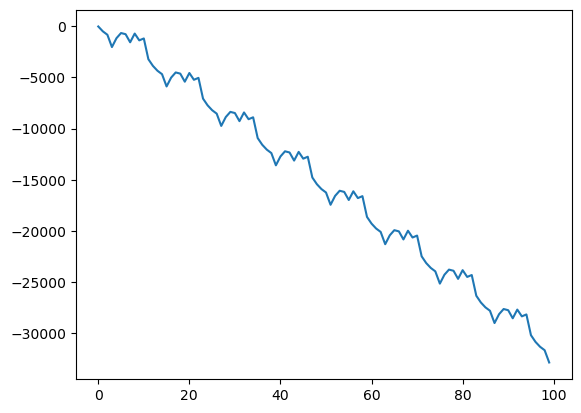

In [66]:
xs[:100].plot()

In [47]:
import statsmodels.api as sm
import pandas as pd


In [48]:
#endog = pd.read_csv('energydata_complete.csv')['RH_5']
endog = pd.DataFrame(xs, columns=['self_generate'])
# We could also fit a more complicated model with seasonal components.
# As an example, here is an SARIMA(1,1,1) x (0,1,1,4):


In [112]:
# num_categories = 60
# n = num_categories

# all_trail_probs = np.zeros((n, n, n))
# num_visited = np.zeros(num_categories)

# df = pd.read_csv('energydata_complete.csv')
# # consider one column first
# #df = df['RH_5']
# #xs = pd.cut(df, bins=num_categories, labels=False)
# res = pd.qcut(df['RH_5'],n, labels=False, retbins=True, precision=3, duplicates='raise')
# # do equal-depth p
# xs = np.array(list(res[0]))
# bins = res[1]


predict_sarima = []
for i in range(100):
    subseq = xs[i:i+window]
    df = pd.DataFrame(subseq)

    mod_sarimax = sm.tsa.SARIMAX(subseq, order=(1,1,1),
                                seasonal_order=(0,1,1,4))
    res_sarimax = mod_sarimax.fit()

    #res = mod_sarimax.filter(res_sarimax.params)

    # Show the summary of results
    pred = res_sarimax.get_prediction(window,window).predicted_mean
    
    predict_sarima.append(pred)
   


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75193D+00    |proj g|=  9.81026D-02

At iterate    5    f=  2.50089D+00    |proj g|=  1.81029D-02

At iterate   10    f=  2.46478D+00    |proj g|=  6.54857D-03

At iterate   15    f=  2.45895D+00    |proj g|=  2.96952D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     29      1     0     0   1.473D-03   2.459D+00
  F =   2.4586303844453030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75181D+00    |proj g|=  9.81427D-02

At iterate    5    f=  2.50085D+00    |proj g|=  1.81060D-02

At iterate   10    f=  2.46478D+00    |proj g|=  7.18517D-03

At iterate   15    f=  2.45877D+00    |proj g|=  1.89847D-02

At iterate   20    f=  2.45853D+00    |proj g|=  9.52821D-04

At iterate   25    f=  2.45853D+00    |proj g|=  1.38038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     45      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75200D+00    |proj g|=  9.81465D-02

At iterate    5    f=  2.50089D+00    |proj g|=  1.81546D-02

At iterate   10    f=  2.46472D+00    |proj g|=  6.74949D-03

At iterate   15    f=  2.45898D+00    |proj g|=  8.46634D-03
  ys=-3.859E-04  -gs= 4.264E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.45858D+00    |proj g|=  8.86272D-05

At iterate   25    f=  2.45858D+00    |proj g|=  1.90138D-04

At iterate   30    f=  2.45858D+00    |proj g|=  1.17627D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     70      2     1     0   1.596D-04   2.459D+00
  F =   2.4585797190834104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75204D+00    |proj g|=  9.81186D-02

At iterate    5    f=  2.50078D+00    |proj g|=  1.81347D-02

At iterate   10    f=  2.46467D+00    |proj g|=  6.72838D-03

At iterate   15    f=  2.45885D+00    |proj g|=  1.56908D-02

At iterate   20    f=  2.45861D+00    |proj g|=  1.83126D-04

At iterate   25    f=  2.45857D+00    |proj g|=  1.37924D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     49      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75200D+00    |proj g|=  9.81379D-02

At iterate    5    f=  2.50087D+00    |proj g|=  1.81690D-02

At iterate   10    f=  2.46467D+00    |proj g|=  6.19595D-03

At iterate   15    f=  2.45865D+00    |proj g|=  7.44068D-03

At iterate   20    f=  2.45857D+00    |proj g|=  6.51336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   6.513D-04   2.459D+00
  F =   2.4585691414041611     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  2.46459D+00    |proj g|=  6.21854D-03

At iterate   15    f=  2.45864D+00    |proj g|=  8.64911D-03

At iterate   20    f=  2.45837D+00    |proj g|=  6.64791D-04

At iterate   25    f=  2.45837D+00    |proj g|=  9.42675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     42      1     0     0   2.647D-04   2.458D+00
  F =   2.4583670610926203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75203D+00    |proj g|=  9.81161D-02

At iterate    5    f=  2.50076D+00    |proj g|=  1.81635D-02

At iterate   10    f=  2.46463D+00    |proj g|=  6.16346D-03

At iterate   15    f=  2.45876D+00    |proj g|=  3.11877D-03

At iterate   20    f=  2.45841D+00    |proj g|=  3.69714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     38      1     0     0   2.408D-04   2.458D+00
  F =   2.4584078926581712     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75207D+00    |proj g|=  9.81072D-02

At iterate    5    f=  2.50094D+00    |proj g|=  1.81808D-02

At iterate   10    f=  2.46475D+00    |proj g|=  5.63494D-03

At iterate   15    f=  2.45855D+00    |proj g|=  1.12733D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     38      1     0     0   1.875D-03   2.458D+00
  F =   2.4583762148727946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75204D+00    |proj g|=  9.81179D-02

At iterate    5    f=  2.50093D+00    |proj g|=  1.81690D-02

At iterate   10    f=  2.46479D+00    |proj g|=  6.21707D-03

At iterate   15    f=  2.45892D+00    |proj g|=  7.74940D-03

At iterate   20    f=  2.45865D+00    |proj g|=  1.28953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   2.543D-04   2.459D+00
  F =   2.4586536939873844     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  2.46484D+00    |proj g|=  5.73390D-03

At iterate   15    f=  2.45886D+00    |proj g|=  1.28058D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   2.634D-03   2.459D+00
  F =   2.4585449541025124     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75228D+00    |proj g|=  9.80510D-02

At iterate    5    f=  2.50102D+00    |proj g|=  1.81292D-02

At iterate   10    f=  2.46494D+00    |proj g|=  6.77518D-03

At iterate   15    f=  2.45879D+00    |proj g|=  4.86449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   8.683D-04   2.459D+00
  F =   2.4587363503513506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75231D+00    |proj g|=  9.80384D-02

At iterate    5    f=  2.50112D+00    |proj g|=  1.81306D-02

At iterate   10    f=  2.46498D+00    |proj g|=  5.88256D-03

At iterate   15    f=  2.45887D+00    |proj g|=  6.77663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   2.790D-03   2.459D+00
  F =   2.4586656905675306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   10    f=  2.46509D+00    |proj g|=  6.37578D-03

At iterate   15    f=  2.45939D+00    |proj g|=  2.06194D-03

At iterate   20    f=  2.45912D+00    |proj g|=  4.61271D-03
  ys=-2.581E-05  -gs= 4.349E-04 BFGS update SKIPPED

At iterate   25    f=  2.45870D+00    |proj g|=  2.42096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     49      1     1     0   5.771D-04   2.459D+00
  F =   2.4586878801551597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75241D+00    |proj g|=  9.80293D-02

At iterate    5    f=  2.50139D+00    |proj g|=  1.81518D-02

At iterate   10    f=  2.46521D+00    |proj g|=  5.60075D-03

At iterate   15    f=  2.45902D+00    |proj g|=  1.35391D-02
  ys=-1.626E-08  -gs= 1.493E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     46      1     1     0   7.091D-03   2.459D+00
  F =   2.4586919331659045     

CONVERGENCE: REL_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75240D+00    |proj g|=  9.80399D-02


 This problem is unconstrained.



At iterate    5    f=  2.50149D+00    |proj g|=  1.89160D-02

At iterate   10    f=  2.46527D+00    |proj g|=  5.18778D-03

At iterate   15    f=  2.45942D+00    |proj g|=  1.88239D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   2.598D-03   2.459D+00
  F =   2.4591667353128734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75238D+00    |proj g|=  9.80342D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  2.46527D+00    |proj g|=  5.54979D-03

At iterate   15    f=  2.45914D+00    |proj g|=  1.44278D-03

At iterate   20    f=  2.45910D+00    |proj g|=  6.30711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   2.089D-04   2.459D+00
  F =   2.4590999952821613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75243D+00    |proj g|=  9.80233D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  2.46532D+00    |proj g|=  5.91984D-03

At iterate   15    f=  2.45944D+00    |proj g|=  6.18459D-03

At iterate   20    f=  2.45910D+00    |proj g|=  1.55170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   5.366D-04   2.459D+00
  F =   2.4590954345134617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75259D+00    |proj g|=  9.80212D-02

At iterate    5    f=  2.50153D+00    |proj g|=  1.81454D-02

At iterate   10    f=  2.46534D+00    |proj g|=  6.45281D-03

At iterate   15    f=  2.45956D+00    |proj g|=  6.44987D-03

At iterate   20    f=  2.45926D+00    |proj g|=  1.53831D-03
  ys=-1.096E-03  -gs= 2.103E-04 BFGS update SKIPPED

At iterate   25    f=  2.45896D+00    |proj g|=  7.60907D-03

At iterate   30    f=  2.45884D+00    |proj g|=  8.97801D-04
  ys=-4.838E-06  -gs= 3.535E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     75      2     2     0   3.921D-04   2.459D+00
  F =   2.4588396754461761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75275D+00    |proj g|=  9.79121D-02

At iterate    5    f=  2.50149D+00    |proj g|=  1.80306D-02

At iterate   10    f=  2.46553D+00    |proj g|=  7.22550D-03

At iterate   15    f=  2.45963D+00    |proj g|=  2.54724D-02
  ys=-1.047E-04  -gs= 1.245E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     37      1     1     0   3.418D-03   2.459D+00
  F =   2.4588769499853815     

CONVERGENCE: REL_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75266D+00    |proj g|=  9.79487D-02

At iterate    5    f=  2.50145D+00    |proj g|=  1.80616D-02


 This problem is unconstrained.



At iterate   10    f=  2.46541D+00    |proj g|=  6.95597D-03

At iterate   15    f=  2.45971D+00    |proj g|=  3.63968D-03

At iterate   20    f=  2.45921D+00    |proj g|=  1.03955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     43      1     0     0   2.487D-03   2.459D+00
  F =   2.4591296314050881     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75256D+00    |proj g|=  9.79807D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  2.46537D+00    |proj g|=  6.99285D-03

At iterate   15    f=  2.45957D+00    |proj g|=  4.13393D-03

At iterate   20    f=  2.45945D+00    |proj g|=  3.73910D-03

At iterate   25    f=  2.45896D+00    |proj g|=  1.05771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     42      1     0     0   1.058D-03   2.459D+00
  F =   2.4589587167775613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75265D+00    |proj g|=  9.79616D-02

At iterate    5    f=  2.50138D+00    |proj g|=  1.80674D-02

At iterate   10    f=  2.46535D+00    |proj g|=  7.01607D-03

At iterate   15    f=  2.45952D+00    |proj g|=  2.37479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   2.022D-03   2.459D+00
  F =   2.4593772674608623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75261D+00    |proj g|=  9.79833D-02

At iterate    5    f=  2.50143D+00    |proj g|=  1.80987D-02

At iterate   10    f=  2.46531D+00    |proj g|=  6.29270D-03

At iterate   15    f=  2.45943D+00    |proj g|=  4.77211D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     38      1     0     0   4.136D-03   2.459D+00
  F =   2.4590939996860461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75263D+00    |proj g|=  9.79900D-02

At iterate    5    f=  2.50147D+00    |proj g|=  1.82951D-02


 This problem is unconstrained.



At iterate   10    f=  2.46535D+00    |proj g|=  5.50374D-03

At iterate   15    f=  2.45916D+00    |proj g|=  6.91619D-04

At iterate   20    f=  2.45901D+00    |proj g|=  1.23349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     51      1     0     0   2.024D-03   2.459D+00
  F =   2.4590015291798664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75253D+00    |proj g|=  9.79542D-02

At iterate    5    f=  2.50143D+00    |proj g|=  1.80955D-02


 This problem is unconstrained.



At iterate   10    f=  2.46539D+00    |proj g|=  5.88201D-03

At iterate   15    f=  2.45916D+00    |proj g|=  1.11646D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     34      1     0     0   1.012D-03   2.459D+00
  F =   2.4589215483421096     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75253D+00    |proj g|=  9.79493D-02

At iterate    5    f=  2.50139D+00    |proj g|=  1.80953D-02


 This problem is unconstrained.



At iterate   10    f=  2.46534D+00    |proj g|=  5.61487D-03

At iterate   15    f=  2.45881D+00    |proj g|=  1.16507D-02
  ys=-3.611E-04  -gs= 1.476E-04 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     40      1     1     0   1.305D-03   2.459D+00
  F =   2.4587386705648817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75249D+00    |proj g|=  9.79610D-02



 This problem is unconstrained.


At iterate    5    f=  2.49008D+00    |proj g|=  3.24940D-02

At iterate   10    f=  2.46218D+00    |proj g|=  8.62761D-04

At iterate   15    f=  2.45953D+00    |proj g|=  3.37950D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     33      1     0     0   1.386D-03   2.459D+00
  F =   2.4591822022365681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75247D+00    |proj g|=  9.79430D-02

At iterate    5    f=  2.50136D+00    |proj g|=  1.80795D-02


 This problem is unconstrained.



At iterate   10    f=  2.46528D+00    |proj g|=  5.74187D-03

At iterate   15    f=  2.45926D+00    |proj g|=  2.20553D-03
  ys=-3.084E-04  -gs= 1.800E-03 BFGS update SKIPPED

At iterate   20    f=  2.45873D+00    |proj g|=  3.17891D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     61      2     1     0   9.882D-04   2.459D+00
  F =   2.4587164593934467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75246D+00    |proj g|=  9.79414D-02



 This problem is unconstrained.


At iterate    5    f=  2.50140D+00    |proj g|=  1.86246D-02

At iterate   10    f=  2.46526D+00    |proj g|=  5.31944D-03

At iterate   15    f=  2.45919D+00    |proj g|=  3.52760D-03
  ys=-1.291E-02  -gs= 2.617E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     40      1     1     0   2.784D-02   2.459D+00
  F =   2.4590882787255905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75239D+00    |proj g|=  9.79392D-02

At iterate    5    f=  2.50142D+00    |proj g|=  1.92787D-02

At iterate   10    f=  2.46529D+00    |proj g|=  4.95733D-03

At iterate   15    f=  2.45941D+00    |proj g|=  1.70864D-02
  ys=-1.841E-03  -gs= 6.315E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.45879D+00    |proj g|=  4.67436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     58      2     1     0   2.473D-04   2.459D+00
  F =   2.4587931158443697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75254D+00    |proj g|=  9.79283D-02

At iterate    5    f=  2.50141D+00    |proj g|=  1.80749D-02

At iterate   10    f=  2.46540D+00    |proj g|=  5.96779D-03

At iterate   15    f=  2.45932D+00    |proj g|=  1.50779D-02

At iterate   20    f=  2.45904D+00    |proj g|=  1.06490D-02

At iterate   25    f=  2.45887D+00    |proj g|=  9.78456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     55      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75247D+00    |proj g|=  9.79812D-02

At iterate    5    f=  2.50149D+00    |proj g|=  1.81179D-02

At iterate   10    f=  2.46543D+00    |proj g|=  5.97881D-03

At iterate   15    f=  2.45950D+00    |proj g|=  3.66176D-03
  ys=-4.776E-04  -gs= 1.429E-03 BFGS update SKIPPED
  ys=-2.123E-03  -gs= 2.039E-03 BFGS update SKIPPED

At iterate   20    f=  2.45882D+00    |proj g|=  3.91542D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

 This problem is unconstrained.



At iterate   10    f=  2.46544D+00    |proj g|=  5.58779D-03

At iterate   15    f=  2.45947D+00    |proj g|=  1.35265D-03

At iterate   20    f=  2.45935D+00    |proj g|=  3.32282D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   3.323D-03   2.459D+00
  F =   2.4593520208024278     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75249D+00    |proj g|=  9.80148D-02

At iterate    5    f=  2.50154D+00    |proj g|=  1.81671D-02

At iterate   10    f=  2.46542D+00    |proj g|=  6.30837D-03

At iterate   15    f=  2.45937D+00    |proj g|=  5.42513D-03

At iterate   20    f=  2.45889D+00    |proj g|=  8.88952D-03

At iterate   25    f=  2.45885D+00    |proj g|=  6.09800D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     51      1     0     0   

 This problem is unconstrained.



At iterate   10    f=  2.46529D+00    |proj g|=  5.36602D-03

At iterate   15    f=  2.45943D+00    |proj g|=  6.34261D-03

At iterate   20    f=  2.45938D+00    |proj g|=  8.07116D-04

At iterate   25    f=  2.45930D+00    |proj g|=  4.01076D-03

At iterate   30    f=  2.45909D+00    |proj g|=  8.72546D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     57      1     0     0   6.299D-04   2.459D+00
  F =   2.4590655422866452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.48993D+00    |proj g|=  2.72109D-02

At iterate   10    f=  2.46211D+00    |proj g|=  8.98152D-04

At iterate   15    f=  2.45890D+00    |proj g|=  1.18728D-02

At iterate   20    f=  2.45880D+00    |proj g|=  5.84871D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     57      2     0     0   7.099D-04   2.459D+00
  F =   2.4588022119113782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75235D+00    |proj g|=  9.80279D-02

At iterate    5    f=  2.48999D+00    |proj g|=  3.17334D-02


 This problem is unconstrained.



At iterate   10    f=  2.46216D+00    |proj g|=  8.78818D-04

At iterate   15    f=  2.45923D+00    |proj g|=  3.06221D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   2.640D-03   2.459D+00
  F =   2.4587761172746774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75247D+00    |proj g|=  9.80499D-02

At iterate    5    f=  2.50170D+00    |proj g|=  1.95811D-02


 This problem is unconstrained.



At iterate   10    f=  2.46540D+00    |proj g|=  4.86544D-03

At iterate   15    f=  2.45952D+00    |proj g|=  9.59333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   8.982D-03   2.459D+00
  F =   2.4591394307632233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75248D+00    |proj g|=  9.80481D-02

At iterate    5    f=  2.48998D+00    |proj g|=  3.00857D-02


 This problem is unconstrained.



At iterate   10    f=  2.46217D+00    |proj g|=  7.80652D-04

At iterate   15    f=  2.45919D+00    |proj g|=  1.93554D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     40      1     0     0   3.485D-03   2.459D+00
  F =   2.4591592275823988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75250D+00    |proj g|=  9.80650D-02

At iterate    5    f=  2.49002D+00    |proj g|=  2.92712D-02


 This problem is unconstrained.



At iterate   10    f=  2.46223D+00    |proj g|=  7.36695D-04

At iterate   15    f=  2.45949D+00    |proj g|=  8.30808D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     33      1     0     0   1.853D-03   2.459D+00
  F =   2.4594385267658541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75235D+00    |proj g|=  9.81422D-02

At iterate    5    f=  2.49039D+00    |proj g|=  1.71088D-02


 This problem is unconstrained.



At iterate   10    f=  2.46218D+00    |proj g|=  2.20263D-03

At iterate   15    f=  2.45885D+00    |proj g|=  4.22797D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     44      1     0     0   1.753D-03   2.459D+00
  F =   2.4588017512422584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75247D+00    |proj g|=  9.81408D-02

At iterate    5    f=  2.49024D+00    |proj g|=  1.93542D-02


 This problem is unconstrained.



At iterate   10    f=  2.46213D+00    |proj g|=  1.20803D-03

At iterate   15    f=  2.45905D+00    |proj g|=  2.99362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     31      1     0     0   2.995D-03   2.459D+00
  F =   2.4590506500321867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75239D+00    |proj g|=  9.81240D-02

At iterate    5    f=  2.49038D+00    |proj g|=  1.83216D-02


 This problem is unconstrained.



At iterate   10    f=  2.46221D+00    |proj g|=  1.52637D-03

At iterate   15    f=  2.45900D+00    |proj g|=  4.41984D-03
  ys=-2.860E-03  -gs= 2.854E-03 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     38      1     1     0   9.503D-03   2.459D+00
  F =   2.4588156611640133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75240D+00    |proj g|=  9.81239D-02

At iterate    5    f=  2.49043D+00    |proj g|=  1.75894D-02

At iterate   10    f=  2.46216D+00    |proj g|=  1.75492D-03

At iterate   15    f=  2.45906D+00    |proj g|=  8.73486D-04

At iterate   20    f=  2.45901D+00    |proj g|=  1.45476D-03

At iterate   25    f=  2.45896D+00    |proj g|=  5.78272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     58      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75248D+00    |proj g|=  9.81002D-02

At iterate    5    f=  2.49076D+00    |proj g|=  1.45459D-02

At iterate   10    f=  2.46221D+00    |proj g|=  1.90530D-03

At iterate   15    f=  2.45919D+00    |proj g|=  1.62702D-02

At iterate   20    f=  2.45865D+00    |proj g|=  1.29937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     41      1     0     0   1.270D-03   2.459D+00
  F =   2.4586455229986779     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75246D+00    |proj g|=  9.81159D-02

At iterate    5    f=  2.49036D+00    |proj g|=  1.87977D-02

At iterate   10    f=  2.46217D+00    |proj g|=  1.27690D-03

At iterate   15    f=  2.45883D+00    |proj g|=  1.20280D-02

At iterate   20    f=  2.45863D+00    |proj g|=  2.02521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     43      1     0     0   3.975D-05   2.459D+00
  F =   2.4586322838144938     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75238D+00    |proj g|=  9.81185D-02

At iterate    5    f=  2.49026D+00    |proj g|=  1.93974D-02

At iterate   10    f=  2.46205D+00    |proj g|=  1.21259D-03

At iterate   15    f=  2.45890D+00    |proj g|=  1.11690D-03
  ys=-6.925E-04  -gs= 2.075E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.45853D+00    |proj g|=  1.77274D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  2.45853D+00    |proj g|=  1.95054D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     84      3     1     0   1.951D-04   2.459D+00
  F =   2.4585344634127475     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75239D+00    |proj g|=  9.80999D-02

At iterate    5    f=  2.49074D+00    |proj g|=  1.31544D-02

At iterate   10    f=  2.46215D+00    |proj g|=  1.09342D-02

At iterate   15    f=  2.45869D+00    |proj g|=  1.32712D-02
  ys=-4.270E-05  -gs= 4.550E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     44      1     1     0   3.943D-03   2.459D+00
  F =   2.4585568607154848     

CONVERGENCE: REL_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75244D+00    |proj g|=  9.80950D-02

At iterate    5    f=  2.49165D+00    |proj g|=  1.26296D-02


 This problem is unconstrained.



At iterate   10    f=  2.46215D+00    |proj g|=  2.01790D-03

At iterate   15    f=  2.45911D+00    |proj g|=  5.00528D-03
  ys=-7.357E-03  -gs= 4.328E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.45859D+00    |proj g|=  3.14317D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     59      2     1     0   7.080D-04   2.459D+00
  F =   2.4585674123776968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75226D+00    |proj g|=  9.81727D-02

At iterate    5    f=  2.49185D+00    |proj g|=  1.27354D-02

At iterate   10    f=  2.46212D+00    |proj g|=  1.94755D-03

At iterate   15    f=  2.45904D+00    |proj g|=  1.03650D-02
  ys=-1.623E-03  -gs= 3.872E-04 BFGS update SKIPPED

At iterate   20    f=  2.45840D+00    |proj g|=  2.33827D-04
  ys=-5.459E-05  -gs= 4.772E-05 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     49      1     2     0   9.006D-04   2.458D+00
  F =   2.4584047991341320     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75234D+00    |proj g|=  9.81583D-02

At iterate    5    f=  2.49118D+00    |proj g|=  1.24341D-02

At iterate   10    f=  2.46192D+00    |proj g|=  2.18981D-03

At iterate   15    f=  2.45887D+00    |proj g|=  8.66166D-03

At iterate   20    f=  2.45877D+00    |proj g|=  1.88347D-03

At iterate   25    f=  2.45875D+00    |proj g|=  8.14268D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     43      1     0     0   

 This problem is unconstrained.



At iterate   10    f=  2.46194D+00    |proj g|=  2.02310D-03

At iterate   15    f=  2.45903D+00    |proj g|=  9.20029D-03

At iterate   20    f=  2.45882D+00    |proj g|=  1.00087D-02

At iterate   25    f=  2.45875D+00    |proj g|=  1.16695D-03

At iterate   30    f=  2.45874D+00    |proj g|=  1.98605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     62      1     0     0   1.735D-03   2.459D+00
  F =   2.4587258580496734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75251D+00    |proj g|=  9.80615D-02

At iterate    5    f=  2.49040D+00    |proj g|=  1.21213D-02

At iterate   10    f=  2.46178D+00    |proj g|=  2.11725D-03

At iterate   15    f=  2.45858D+00    |proj g|=  7.51007D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     35      1     0     0   7.518D-03   2.459D+00
  F =   2.4585831696146685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75234D+00    |proj g|=  9.80774D-02

At iterate    5    f=  2.49253D+00    |proj g|=  1.32819D-02

At iterate   10    f=  2.46208D+00    |proj g|=  1.53806D-03

At iterate   15    f=  2.45821D+00    |proj g|=  6.72286D-03
  ys=-9.982E-05  -gs= 3.495E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     42      1     1     0   1.012D-03   2.458D+00
  F =   2.4581513194660736     

CONVERGENCE: REL_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75220D+00    |proj g|=  9.81475D-02


 This problem is unconstrained.



At iterate    5    f=  2.49196D+00    |proj g|=  1.30330D-02

At iterate   10    f=  2.46188D+00    |proj g|=  1.65205D-03

At iterate   15    f=  2.45823D+00    |proj g|=  5.54071D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   2.371D-04   2.458D+00
  F =   2.4581460161357738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75226D+00    |proj g|=  9.81265D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  2.46198D+00    |proj g|=  1.55833D-03

At iterate   15    f=  2.45821D+00    |proj g|=  6.45653D-03
  ys=-8.296E-03  -gs= 1.485E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.45814D+00    |proj g|=  6.47163D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     59      2     1     0   5.284D-04   2.458D+00
  F =   2.4581397815592441     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75212D+00    |proj g|=  9.81153D-02


 This problem is unconstrained.



At iterate    5    f=  2.49168D+00    |proj g|=  1.28634D-02

At iterate   10    f=  2.46191D+00    |proj g|=  1.64638D-03

At iterate   15    f=  2.45856D+00    |proj g|=  3.51288D-03

At iterate   20    f=  2.45820D+00    |proj g|=  1.81139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     43      1     0     0   1.811D-03   2.458D+00
  F =   2.4581982081996352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.49087D+00    |proj g|=  1.24405D-02

At iterate   10    f=  2.46179D+00    |proj g|=  2.15212D-03

At iterate   15    f=  2.45885D+00    |proj g|=  1.74772D-02

At iterate   20    f=  2.45825D+00    |proj g|=  5.38972D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   4.643D-04   2.458D+00
  F =   2.4582474655115218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  2.46187D+00    |proj g|=  1.54261D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  2.45838D+00    |proj g|=  2.95456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     44      2     0     0   8.221D-05   2.458D+00
  F =   2.4583622864768389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75193D+00    |proj g|=  9.81355D-02

At iterate    5    f=  2.49148D+00    |proj g|=  1.29087D-02


 This problem is unconstrained.



At iterate   10    f=  2.46168D+00    |proj g|=  1.56379D-03

At iterate   15    f=  2.45839D+00    |proj g|=  1.97545D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     31      1     0     0   5.423D-03   2.458D+00
  F =   2.4583014619142922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75176D+00    |proj g|=  9.81094D-02


 This problem is unconstrained.



At iterate    5    f=  2.49021D+00    |proj g|=  1.22390D-02

At iterate   10    f=  2.46150D+00    |proj g|=  2.16121D-03

At iterate   15    f=  2.45840D+00    |proj g|=  1.26296D-02

At iterate   20    f=  2.45819D+00    |proj g|=  1.75771D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     43      1     0     0   1.758D-02   2.458D+00
  F =   2.4581866543873829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75174D+00    |proj g|=  9.81228D-02


 This problem is unconstrained.



At iterate    5    f=  2.48905D+00    |proj g|=  1.22671D-02

At iterate   10    f=  2.46126D+00    |proj g|=  1.96559D-03

At iterate   15    f=  2.45846D+00    |proj g|=  3.12069D-03

At iterate   20    f=  2.45814D+00    |proj g|=  2.34208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     40      1     0     0   2.341D-03   2.458D+00
  F =   2.4581362721345301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  2.46129D+00    |proj g|=  2.06684D-03

At iterate   15    f=  2.45804D+00    |proj g|=  4.83828D-03

At iterate   20    f=  2.45801D+00    |proj g|=  2.28394D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  2.45801D+00    |proj g|=  1.86627D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     54      2     0     0   1.866D-04   2.458D+00
  F =   2.4580104549422015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75173D+00    |proj g|=  9.81196D-02

At iterate    5    f=  2.48999D+00    |proj g|=  1.22814D-02


 This problem is unconstrained.



At iterate   10    f=  2.46132D+00    |proj g|=  1.84321D-03

At iterate   15    f=  2.45817D+00    |proj g|=  3.03964D-03

At iterate   20    f=  2.45793D+00    |proj g|=  2.85273D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     53      1     0     0   2.895D-03   2.458D+00
  F =   2.4578952145323343     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75161D+00    |proj g|=  9.81659D-02

At iterate    5    f=  2.49333D+00    |proj g|=  1.40778D-02


 This problem is unconstrained.



At iterate   10    f=  2.46185D+00    |proj g|=  1.84250D-03

At iterate   15    f=  2.45777D+00    |proj g|=  5.54777D-03
  ys=-5.558E-05  -gs= 1.640E-04 BFGS update SKIPPED

At iterate   20    f=  2.45769D+00    |proj g|=  1.65776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     45      1     1     0   2.056D-04   2.458D+00
  F =   2.4576876898289242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75166D+00    |proj g|=  9.81572D-02

At iterate    5    f=  2.49177D+00    |proj g|=  1.32661D-02

At iterate   10    f=  2.46150D+00    |proj g|=  1.45074D-03

At iterate   15    f=  2.45794D+00    |proj g|=  4.45094D-03
  ys=-1.353E-04  -gs= 4.256E-05 BFGS update SKIPPED

At iterate   20    f=  2.45758D+00    |proj g|=  8.29860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     48      1     1     0   8.299D-04 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75162D+00    |proj g|=  9.81639D-02

At iterate    5    f=  2.49240D+00    |proj g|=  1.36687D-02

At iterate   10    f=  2.46150D+00    |proj g|=  1.41203D-03

At iterate   15    f=  2.45782D+00    |proj g|=  8.06365D-03
  ys=-3.168E-04  -gs= 2.790E-05 BFGS update SKIPPED

At iterate   20    f=  2.45747D+00    |proj g|=  4.43977D-03
  ys=-4.160E-04  -gs= 3.207E-04 BFGS update SKIPPED

At iterate   25    f=  2.45746D+00    |proj g|=  6.39882D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75155D+00    |proj g|=  9.81585D-02

At iterate    5    f=  2.49253D+00    |proj g|=  1.37219D-02


 This problem is unconstrained.



At iterate   10    f=  2.46156D+00    |proj g|=  1.40896D-03

At iterate   15    f=  2.45815D+00    |proj g|=  3.28252D-03

At iterate   20    f=  2.45812D+00    |proj g|=  3.10547D-03

At iterate   25    f=  2.45810D+00    |proj g|=  8.64425D-04

At iterate   30    f=  2.45796D+00    |proj g|=  3.42737D-03

At iterate   35    f=  2.45796D+00    |proj g|=  2.85897D-04

At iterate   40    f=  2.45796D+00    |proj g|=  3.86938D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     62      1     0     0   1.193D-04   2.458D+00
  F =   2.4579560714143556     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.49217D+00    |proj g|=  1.35235D-02

At iterate   10    f=  2.46149D+00    |proj g|=  1.43766D-03

At iterate   15    f=  2.45800D+00    |proj g|=  6.04580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     33      1     0     0   1.200D-03   2.458D+00
  F =   2.4579110769509769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75142D+00    |proj g|=  9.82307D-02


 This problem is unconstrained.



At iterate    5    f=  2.49266D+00    |proj g|=  1.38555D-02

At iterate   10    f=  2.46151D+00    |proj g|=  1.42182D-03

At iterate   15    f=  2.45807D+00    |proj g|=  3.19924D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     34      1     0     0   1.124D-02   2.458D+00
  F =   2.4579235071625409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75156D+00    |proj g|=  9.82160D-02

At iterate    5    f=  2.49206D+00    |proj g|=  1.34802D-02

At iterate   10    f=  2.46143D+00    |proj g|=  1.47546D-03

At iterate   15    f=  2.45799D+00    |proj g|=  2.31734D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     34      1     0     0   1.321D-03   2.458D+00
  F =   2.4578936196961632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75154D+00    |proj g|=  9.82168D-02

At iterate    5    f=  2.49215D+00    |proj g|=  1.35233D-02


 This problem is unconstrained.



At iterate   10    f=  2.46144D+00    |proj g|=  1.49307D-03

At iterate   15    f=  2.45794D+00    |proj g|=  2.67775D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     30      1     0     0   2.673D-03   2.458D+00
  F =   2.4579396027569520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75170D+00    |proj g|=  9.81759D-02

At iterate    5    f=  2.49179D+00    |proj g|=  1.33703D-02


 This problem is unconstrained.



At iterate   10    f=  2.46137D+00    |proj g|=  1.43079D-03

At iterate   15    f=  2.45772D+00    |proj g|=  4.55279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   2.224D-03   2.458D+00
  F =   2.4576403462311460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75166D+00    |proj g|=  9.81531D-02

At iterate    5    f=  2.49145D+00    |proj g|=  1.31755D-02

At iterate   10    f=  2.46136D+00    |proj g|=  1.43738D-03

At iterate   15    f=  2.45810D+00    |proj g|=  8.98222D-03
  ys=-2.728E-04  -gs= 4.205E-04 BFGS update SKIPPED

At iterate   20    f=  2.45750D+00    |proj g|=  2.88391D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     53      1     1     0   2.930D-04   2.458D+00
  F =   2.4575026495171688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75162D+00    |proj g|=  9.81804D-02

At iterate    5    f=  2.49181D+00    |proj g|=  1.34016D-02


 This problem is unconstrained.



At iterate   10    f=  2.46136D+00    |proj g|=  1.43565D-03

At iterate   15    f=  2.45803D+00    |proj g|=  2.66183D-03

At iterate   20    f=  2.45796D+00    |proj g|=  4.54095D-03

At iterate   25    f=  2.45793D+00    |proj g|=  1.11207D-04

At iterate   30    f=  2.45792D+00    |proj g|=  2.87670D-03

At iterate   35    f=  2.45790D+00    |proj g|=  2.02740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     67      1     0     0   1.047D-03   2.458D+00
  F =   2.4578966018808726     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.49227D+00    |proj g|=  1.36399D-02

At iterate   10    f=  2.46144D+00    |proj g|=  1.42151D-03

At iterate   15    f=  2.45757D+00    |proj g|=  1.59138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     41      1     0     0   1.925D-03   2.457D+00
  F =   2.4574947920575152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75160D+00    |proj g|=  9.81749D-02

At iterate    5    f=  2.49149D+00    |proj g|=  1.32470D-02

At iterate   10    f=  2.46127D+00    |proj g|=  1.45847D-03

At iterate   15    f=  2.45778D+00    |proj g|=  8.59211D-03

At iterate   20    f=  2.45771D+00    |proj g|=  2.53538D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     44      1     0     0   3.606D-03   2.458D+00
  F =   2.4576357841170307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75157D+00    |proj g|=  9.81693D-02

At iterate    5    f=  2.49165D+00    |proj g|=  1.33451D-02


 This problem is unconstrained.



At iterate   10    f=  2.46131D+00    |proj g|=  1.44276D-03

At iterate   15    f=  2.45778D+00    |proj g|=  3.14450D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     26      1     0     0   2.421D-04   2.458D+00
  F =   2.4577770339785476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75159D+00    |proj g|=  9.81624D-02

At iterate    5    f=  2.49113D+00    |proj g|=  1.30709D-02


 This problem is unconstrained.



At iterate   10    f=  2.46123D+00    |proj g|=  1.46149D-03

At iterate   15    f=  2.45800D+00    |proj g|=  7.92168D-03

At iterate   20    f=  2.45773D+00    |proj g|=  3.73727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     43      1     0     0   1.817D-03   2.458D+00
  F =   2.4576922646062211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75160D+00    |proj g|=  9.81588D-02

At iterate    5    f=  2.49109D+00    |proj g|=  1.30249D-02

At iterate   10    f=  2.46128D+00    |proj g|=  1.45594D-03

At iterate   15    f=  2.45810D+00    |proj g|=  3.61135D-03
  ys=-2.717E-03  -gs= 7.423E-04 BFGS update SKIPPED

At iterate   20    f=  2.45742D+00    |proj g|=  2.05141D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     43      1     1     0   2.057D-03 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75158D+00    |proj g|=  9.81121D-02

At iterate    5    f=  2.49009D+00    |proj g|=  1.25019D-02

At iterate   10    f=  2.46115D+00    |proj g|=  1.53092D-03

At iterate   15    f=  2.45778D+00    |proj g|=  2.79577D-03

At iterate   20    f=  2.45752D+00    |proj g|=  4.38101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     46      1     0     0   4.317D-04   2.458D+00
  F =   2.4575186612834496     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.49131D+00    |proj g|=  1.31323D-02

At iterate   10    f=  2.46136D+00    |proj g|=  1.40044D-03

At iterate   15    f=  2.45793D+00    |proj g|=  6.65720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     37      1     0     0   5.384D-04   2.458D+00
  F =   2.4577642914973969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75168D+00    |proj g|=  9.80944D-02

At iterate    5    f=  2.49060D+00    |proj g|=  1.27880D-02

At iterate   10    f=  2.46119D+00    |proj g|=  1.43283D-03

At iterate   15    f=  2.45777D+00    |proj g|=  6.59272D-03
  ys=-7.082E-04  -gs= 1.522E-04 BFGS update SKIPPED
  ys=-1.281E-04  -gs= 1.538E-04 BFGS update SKIPPED

At iterate   20    f=  2.45742D+00    |proj g|=  1.05013D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

 This problem is unconstrained.



At iterate   10    f=  2.46101D+00    |proj g|=  1.59902D-03

At iterate   15    f=  2.45764D+00    |proj g|=  8.40436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     34      1     0     0   4.948D-04   2.458D+00
  F =   2.4575886006010959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75156D+00    |proj g|=  9.80620D-02

At iterate    5    f=  2.48800D+00    |proj g|=  1.14977D-02

At iterate   10    f=  2.46082D+00    |proj g|=  2.11271D-03

At iterate   15    f=  2.45767D+00    |proj g|=  2.17892D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     38      1     0     0   2.910D-03   2.457D+00
  F =   2.4573902762379127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  2.48866D+00    |proj g|=  1.18152D-02

At iterate   10    f=  2.46093D+00    |proj g|=  1.68399D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f=  2.45778D+00    |proj g|=  2.16988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     31      1     0     0   2.170D-03   2.458D+00
  F =   2.4577789980771376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75158D+00    |proj g|=  9.79797D-02


 This problem is unconstrained.



At iterate    5    f=  2.48669D+00    |proj g|=  1.25009D-02

At iterate   10    f=  2.46088D+00    |proj g|=  5.66351D-03

At iterate   15    f=  2.45763D+00    |proj g|=  2.46866D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     34      1     0     0   2.041D-03   2.458D+00
  F =   2.4576291136932786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75151D+00    |proj g|=  9.80067D-02

At iterate    5    f=  2.50009D+00    |proj g|=  2.02084D-02


 This problem is unconstrained.



At iterate   10    f=  2.46412D+00    |proj g|=  4.03215D-03

At iterate   15    f=  2.45820D+00    |proj g|=  9.34820D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   5.676D-03   2.458D+00
  F =   2.4578884608248348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75137D+00    |proj g|=  9.79972D-02

At iterate    5    f=  2.50006D+00    |proj g|=  1.84773D-02


 This problem is unconstrained.



At iterate   10    f=  2.46409D+00    |proj g|=  5.10781D-03

At iterate   15    f=  2.45756D+00    |proj g|=  1.43233D-02
  ys=-3.803E-05  -gs= 5.707E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     45      1     1     0   5.293D-03   2.457D+00
  F =   2.4574882857628038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75132D+00    |proj g|=  9.79724D-02

At iterate    5    f=  2.48619D+00    |proj g|=  2.37399D-02

At iterate   10    f=  2.46066D+00    |proj g|=  8.55838D-04

At iterate   15    f=  2.45758D+00    |proj g|=  5.23779D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.45753D+00    |proj g|=  1.40619D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     53      2     0     0   1.406D-04   2.458D+00
  F =   2.4575302173067768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75139D+00    |proj g|=  9.79299D-02

At iterate    5    f=  2.50000D+00    |proj g|=  2.10707D-02


 This problem is unconstrained.



At iterate   10    f=  2.46411D+00    |proj g|=  3.29581D-03

At iterate   15    f=  2.45823D+00    |proj g|=  1.84152D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     36      1     0     0   1.634D-02   2.458D+00
  F =   2.4575503706952535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75121D+00    |proj g|=  9.79923D-02

At iterate    5    f=  2.49997D+00    |proj g|=  2.02648D-02


 This problem is unconstrained.



At iterate   10    f=  2.46401D+00    |proj g|=  4.03228D-03

At iterate   15    f=  2.45810D+00    |proj g|=  6.47337D-03
  ys=-1.003E-03  -gs= 1.448E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     43      1     1     0   1.238D-02   2.458D+00
  F =   2.4575879815409882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75123D+00    |proj g|=  9.79703D-02

At iterate    5    f=  2.49986D+00    |proj g|=  1.85641D-02


 This problem is unconstrained.



At iterate   10    f=  2.46389D+00    |proj g|=  5.06336D-03

At iterate   15    f=  2.45767D+00    |proj g|=  2.68206D-02
  ys=-1.831E-05  -gs= 3.154E-06 BFGS update SKIPPED

At iterate   20    f=  2.45726D+00    |proj g|=  2.99370D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     47      1     1     0   5.512D-04   2.457D+00
  F =   2.4572563106507745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate   10    f=  2.46378D+00    |proj g|=  4.04225D-03

At iterate   15    f=  2.45799D+00    |proj g|=  4.39413D-03

At iterate   20    f=  2.45733D+00    |proj g|=  2.86774D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     35      1     0     0   2.868D-03   2.457D+00
  F =   2.4573309388923277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75104D+00    |proj g|=  9.80267D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  2.46037D+00    |proj g|=  1.36769D-03

At iterate   15    f=  2.45764D+00    |proj g|=  5.69587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     29      1     0     0   5.696D-03   2.458D+00
  F =   2.4576371565438078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75098D+00    |proj g|=  9.80505D-02

At iterate    5    f=  2.49966D+00    |proj g|=  1.94232D-02


 This problem is unconstrained.



At iterate   10    f=  2.46362D+00    |proj g|=  4.65145D-03

At iterate   15    f=  2.45773D+00    |proj g|=  1.11791D-02

At iterate   20    f=  2.45725D+00    |proj g|=  3.02894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     42      1     0     0   1.387D-03   2.457D+00
  F =   2.4572344504499370     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75099D+00    |proj g|=  9.80599D-02

At iterate    5    f=  2.48712D+00    |proj g|=  3.06747D-02

At iterate   10    f=  2.46029D+00    |proj g|=  1.19576D-03

At iterate   15    f=  2.45765D+00    |proj g|=  2.47356D-03

At iterate   20    f=  2.45755D+00    |proj g|=  1.54748D-03

At iterate   25    f=  2.45733D+00    |proj g|=  9.17238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     57      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75096D+00    |proj g|=  9.80548D-02


 This problem is unconstrained.



At iterate    5    f=  2.48728D+00    |proj g|=  3.18696D-02

At iterate   10    f=  2.46037D+00    |proj g|=  1.33105D-03

At iterate   15    f=  2.45750D+00    |proj g|=  2.60485D-03

At iterate   20    f=  2.45742D+00    |proj g|=  3.42508D-03

At iterate   25    f=  2.45739D+00    |proj g|=  3.43774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     49      1     0     0   2.650D-04   2.457D+00
  F =   2.4573923520551562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  2.46028D+00    |proj g|=  1.10129D-03

At iterate   15    f=  2.45739D+00    |proj g|=  1.49456D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     36      1     0     0   1.494D-02   2.457D+00
  F =   2.4573941492750841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75094D+00    |proj g|=  9.80521D-02

At iterate    5    f=  2.48726D+00    |proj g|=  3.24223D-02

At iterate   10    f=  2.46031D+00    |proj g|=  1.40520D-03

At iterate   15    f=  2.45738D+00    |proj g|=  4.34514D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.45731D+00    |proj g|=  1.83097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     47      2     0     0   1.585D-04   2.457D+00
  F =   2.4573062114493136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [63]:
predict_sarima = np.array(predict_sarima).squeeze()
diff = abs(predict_sarima - xs[window : window+100])
diff.std()

238.70107919206936

10000

In [54]:
xs[window: window + 100]

10000   -3.209252e+06
10001   -3.208750e+06
10002   -3.208866e+06
10003   -3.209656e+06
10004   -3.208805e+06
             ...     
10095   -3.240929e+06
10096   -3.240061e+06
10097   -3.239560e+06
10098   -3.239672e+06
10099   -3.240465e+06
Name: y, Length: 100, dtype: float64

In [55]:
predict_sarima = np.array(predict_sarima).astype(int).reshape(1,-1)
print((predict_sarima == xs[window: window + 100]).astype(int).mean())

/var/folders/kx/06y42x8s5571j9jqkpc5wf500000gn/T/ipykernel_4386/2004419417.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print((predict_sarima == xs[window: window + 100]).astype(int).mean())


ValueError: ('Lengths must match to compare', (100,), (1, 100))